<a href="https://colab.research.google.com/github/sibaysky/MarketSalesForecast/blob/main/DiplomSem2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт библиотек

Импорт pandas и numpy для работы с данными, а также LabelEncoder и StandardScaler из sklearn для предобработки.

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import torch.nn as nn

# Загрузка данных

Загрузка обучающего, тестового и справочных датасетов с помощью pandas.


In [ ]:
# Загрузка данных

from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

Mounted at /content/drive/


# Предобработка и агрегация данных

Агрегируем продажи по месяцам, ограничиваем значения, объединяем со справочниками.  
Создаем дополнительные признаки: средние продажи и цены, категориальные уровни, классы спроса и цен.  
Применяем кодирование категорий и стандартизацию числовых признаков для последующего использования в модели.


In [ ]:
# Агрегация: суммируем продажи по месяцам
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                         'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                         'item_price_mean', 'item_price_max']

# Ограничим продажи до [0, 20], как требует Kaggle
monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')

# Кодируем категориальные признаки
for col in ['shop_id', 'item_id', 'item_category_id']:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col])

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')

monthly_sales.rename(columns={'item_cnt_sum': 'target'}, inplace=True)
monthly_sales['log_target'] = np.log1p(monthly_sales['target'])

# Обработка текстов
def normalize_name(name):
    import re
    name = name.lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_sku_name'] = LabelEncoder().fit_transform(monthly_sales['normalized_sku_name'])

monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(lambda x: x.split(' ')[0])
monthly_sales['sku_level_1_category'] = LabelEncoder().fit_transform(monthly_sales['sku_level_1_category'])

monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 3, labels=False)
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 3, labels=False)

# Списки фичей
cat_features = ['item_id', 'item_category_id', 'normalized_sku_name',
                'sku_level_1_category', 'price_class', 'demand_class']

embed_sizes = {col: monthly_sales[col].nunique() for col in cat_features}
num_features = ['item_cnt_mean', 'item_cnt_count', 'item_price_mean',
                'item_price_max', 'item_avg_sales', 'item_avg_price', 'shop_avg_sales']

#Добавим стандартизацию числовых признаков
scaler = StandardScaler()
X_num = scaler.fit_transform(monthly_sales[num_features]).astype(np.float32)

X_cat = monthly_sales[cat_features].values.astype(np.int64)
y = monthly_sales['log_target'].values.astype(np.float32)

#Нормализуем цену
item_price = monthly_sales['item_price_mean'].clip(1e-2)  # избегаем log(0)
price_tensor = item_price.values / item_price.max()
price_tensor = price_tensor.astype(np.float32)

# Модель ElasticityModel

Определяем нейросетевую архитектуру на базе `nn.Module` для оценки эластичности спроса.  
Модель использует эмбеддинги категориальных признаков, полносвязный слой для числовых, и два линейных выхода:
- один для лог-спроса (baseline),
- второй — для лог-множителя эластичности (ограничен через tanh).

Финальный прогноз лог-спроса корректируется с учетом логарифма цены.


In [ ]:
class ElasticityModel(nn.Module):
    def __init__(self, embed_sizes, num_numerical):
        super().__init__()
        self.embeddings = nn.ModuleDict({
            col: nn.Embedding(n, min(50, (n + 1) // 2)) for col, n in embed_sizes.items()
        })
        emb_dim = sum([emb.embedding_dim for emb in self.embeddings.values()])
        self.bn_num = nn.BatchNorm1d(num_numerical)
        self.fc_num = nn.Linear(num_numerical, 64)
        self.encoder_demand = nn.Linear(emb_dim + 64, 1)
        self.encoder_elasticity = nn.Linear(emb_dim + 64, 1)

    def forward(self, x_cat, x_num, log_price):
        x_emb = [self.embeddings[col](x_cat[:, i]) for i, col in enumerate(embed_sizes)]
        x_emb = torch.cat(x_emb, dim=1)
        x_num = self.bn_num(x_num)
        x_num_proj = F.relu(self.fc_num(x_num))
        x = torch.cat([x_emb, x_num_proj], dim=1)

        log_demand = self.encoder_demand(x)
        raw_mul = self.encoder_elasticity(x)

        # Ограничим log_mul от -5 до 5
        log_mul = 5.0 * torch.tanh(raw_mul)

        # Прогноз лог-спроса
        pred = log_demand - log_mul * log_price.view(-1, 1)
        return pred.squeeze()


# Обучение модели

Подготовка данных для обучения с использованием `TensorDataset` и `DataLoader`.  
Инициализация модели, оптимизатора (Adam) и функции потерь (MSE).  
Обучение проводится в течение 5 эпох с расчётом и выводом средней потери на каждой эпохе.


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
import torch

X_num_tensor = torch.tensor(X_num)
X_cat_tensor = torch.tensor(X_cat)
y_tensor = torch.tensor(y)
log_price_tensor = torch.tensor(np.log1p(price_tensor))

dataset = TensorDataset(X_cat_tensor, X_num_tensor, log_price_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)

model = ElasticityModel(embed_sizes, X_num.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for x_cat_b, x_num_b, log_price_b, y_b in dataloader:
        optimizer.zero_grad()
        pred = model(x_cat_b, x_num_b, log_price_b)
        loss = loss_fn(pred, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_cat_b.size(0)
    print(f"Epoch {epoch}, Loss: {total_loss / len(dataloader.dataset):.4f}")


# Визуализация кривых спроса

Строим кривые зависимости спроса от цены для первых 5 товаров.  
Для каждого товара варьируем цену и предсказываем спрос, отображая результаты на графике.


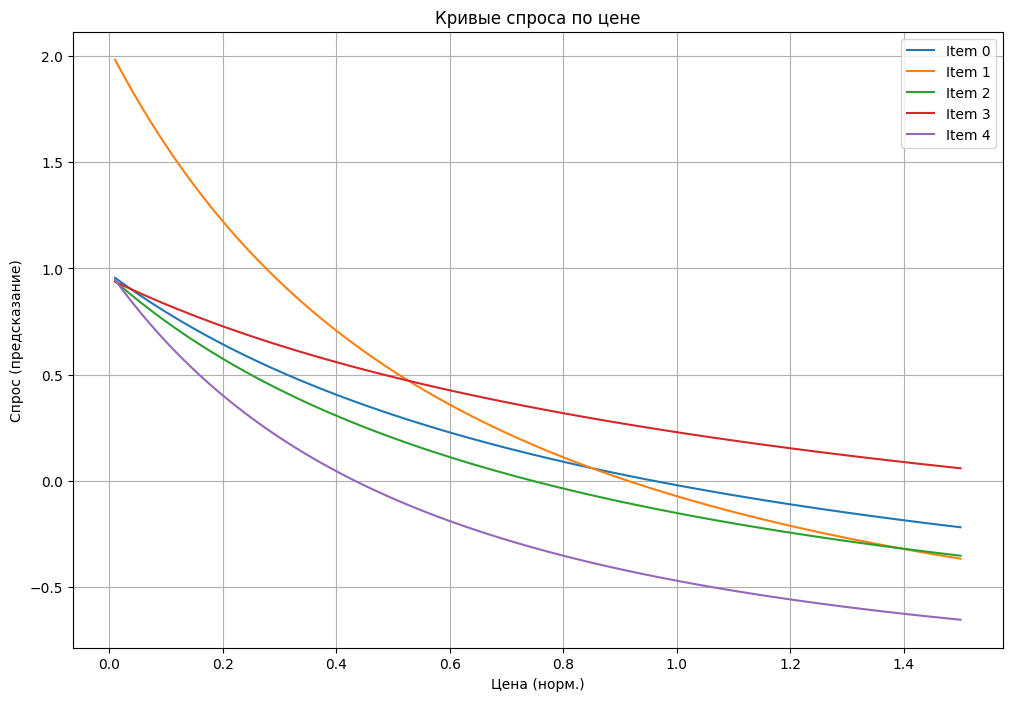

In [ ]:
import matplotlib.pyplot as plt

model.eval()
top_items = np.unique(X_cat_tensor[:, 0].numpy())[:5]  # первые 5 item_id (можно заменить на топ по продажам)

plt.figure(figsize=(12, 8))
for item_id in top_items:
    # Найдём первую строку с этим item_id
    idx = (X_cat_tensor[:, 0] == item_id).nonzero(as_tuple=True)[0][0]

    # Возьмём категориальные и числовые фичи
    x_cat_base = X_cat_tensor[idx].unsqueeze(0).repeat(100, 1)
    x_num_base = X_num_tensor[idx].unsqueeze(0).repeat(100, 1)

    # Разные цены в лог-пространстве
    prices = np.linspace(0.01, 1.5, 100)
    log_prices = torch.tensor(np.log1p(prices), dtype=torch.float32)

    preds = model(x_cat_base, x_num_base, log_prices).detach().numpy()
    demand = np.expm1(preds)  # переводим из log(1 + y)

    plt.plot(prices, demand, label=f"Item {item_id}")

plt.xlabel("Цена (норм.)")
plt.ylabel("Спрос (предсказание)")
plt.title("Кривые спроса по цене")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
elasticities = []
for i in range(len(X_cat_tensor)):
    with torch.no_grad():
        x_cat_b = X_cat_tensor[i].unsqueeze(0)
        x_num_b = X_num_tensor[i].unsqueeze(0)
        log_price_b = log_price_tensor[i].unsqueeze(0)

        x_emb = [model.embeddings[col](x_cat_b[:, j]) for j, col in enumerate(embed_sizes)]
        x_emb = torch.cat(x_emb, dim=1)
        x_num_proj = F.relu(model.fc_num(model.bn_num(x_num_b)))
        x = torch.cat([x_emb, x_num_proj], dim=1)

        elasticity = 5.0 * torch.tanh(model.encoder_elasticity(x))  # bounded
        elasticities.append(elasticity.item())

plt.hist(elasticities, bins=50)
plt.title("Распределение эластичности")
plt.xlabel("Эластичность")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.show()


# Анализ распределения эластичности

Извлекаем значения эластичности из обученной модели для всех наблюдений.  
Строим гистограмму, чтобы визуализировать распределение эластичности спроса по товарам.


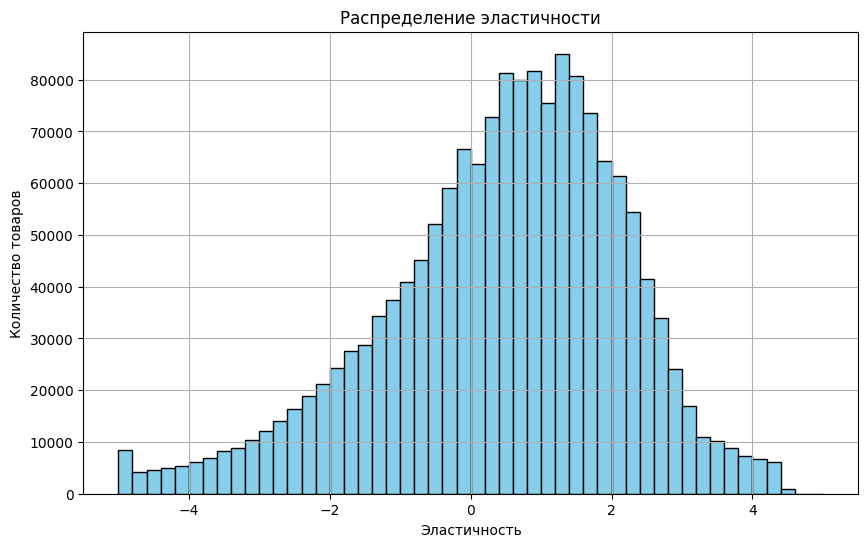

In [ ]:
import torch.nn.functional as F

# Получаем выходы модели
with torch.no_grad():
    # Прогоняем всё сразу
    x_emb = [model.embeddings[col](X_cat_tensor[:, j]) for j, col in enumerate(embed_sizes)]
    x_emb = torch.cat(x_emb, dim=1)
    x_num_proj = F.relu(model.fc_num(model.bn_num(X_num_tensor)))
    x = torch.cat([x_emb, x_num_proj], dim=1)

    elasticities = 5.0 * torch.tanh(model.encoder_elasticity(x)).squeeze().numpy()

# Визуализация
plt.figure(figsize=(10, 6))
plt.hist(elasticities, bins=50, color="skyblue", edgecolor="black")
plt.title("Распределение эластичности")
plt.xlabel("Эластичность")
plt.ylabel("Количество товаров")
plt.grid(True)
plt.show()


# Анализ кривых прибыли

На основе предсказанного спроса и заданной себестоимости рассчитываем прибыль для разных цен.  
Строим графики зависимости прибыли от цены для выбранных товаров.


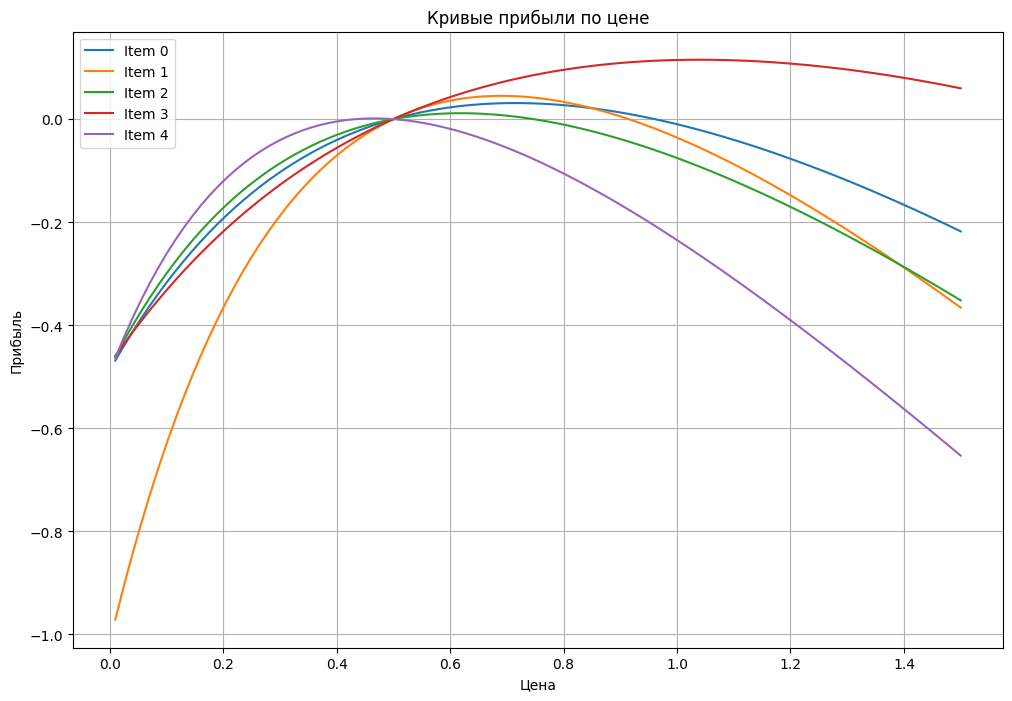

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Примерные значения себестоимости для каждого товара
costs = {item_id: 0.5 for item_id in top_items}  # Замените на реальные значения

plt.figure(figsize=(12, 8))
for item_id in top_items:
    # Найдём первую строку с этим item_id
    idx = (X_cat_tensor[:, 0] == item_id).nonzero(as_tuple=True)[0][0]

    # Возьмём категориальные и числовые фичи
    x_cat_base = X_cat_tensor[idx].unsqueeze(0).repeat(100, 1)
    x_num_base = X_num_tensor[idx].unsqueeze(0).repeat(100, 1)

    # Разные цены
    prices = np.linspace(0.01, 1.5, 100)
    log_prices = torch.tensor(np.log1p(prices), dtype=torch.float32)

    preds = model(x_cat_base, x_num_base, log_prices).detach().numpy()
    demand = np.expm1(preds)  # переводим из log(1 + y)

    profit = (prices - costs[item_id]) * demand
    plt.plot(prices, profit, label=f"Item {item_id}")

plt.xlabel("Цена")
plt.ylabel("Прибыль")
plt.title("Кривые прибыли по цене")
plt.legend()
plt.grid(True)
plt.show()


# Оценка качества модели

Определены функции для расчёта ключевых метрик качества:  
- R² (коэффициент детерминации)  
- MAE (средняя абсолютная ошибка)  
- MAPE (средняя абсолютная процентная ошибка)  

Функция `evaluate_metrics` выводит и возвращает значения метрик для удобства сравнения моделей.


In [ ]:
from sklearn.metrics import r2_score, mean_absolute_error
import numpy as np
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F

# Функция для MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_idx = y_true != 0
    return np.mean(np.abs((y_true[nonzero_idx] - y_pred[nonzero_idx]) / y_true[nonzero_idx])) * 100

# Функция для расчета всех метрик
def evaluate_metrics(y_true, y_pred, name='Model'):
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    print(f"[{name}] R2: {r2:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")
    return r2, mae, mape


# Разделение данных на обучающую и тестовую выборки

Разбиваем данные в пропорции 80/20 для обучения и оценки модели.  
Создаем соответствующие `TensorDataset` и `DataLoader` для удобной подачи данных на обучение и тестирование.


In [ ]:
# Допустим 80% train, 20% test
from sklearn.model_selection import train_test_split

X_cat_train, X_cat_test, X_num_train, X_num_test, y_train, y_test, log_price_train, log_price_test = train_test_split(
    X_cat_tensor, X_num_tensor, y_tensor, log_price_tensor, test_size=0.2, random_state=42
)

train_dataset = TensorDataset(X_cat_train, X_num_train, log_price_train, y_train)
test_dataset = TensorDataset(X_cat_test, X_num_test, log_price_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)


# Обучение модели на тренировочной выборке

Инициализация модели, оптимизатора и функции потерь.  
Обучение проводится в течение 5 эпох с подсчетом средней ошибки на тренировочных данных.


In [ ]:
model = ElasticityModel(embed_sizes, X_num.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.MSELoss()

for epoch in range(1, 6):
    model.train()
    total_loss = 0
    for x_cat_b, x_num_b, log_price_b, y_b in train_loader:
        optimizer.zero_grad()
        pred = model(x_cat_b, x_num_b, log_price_b)
        loss = loss_fn(pred, y_b)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * x_cat_b.size(0)
    print(f"Epoch {epoch}, Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch 1, Loss: 0.0265
Epoch 2, Loss: 0.0051
Epoch 3, Loss: 0.0046
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0035


# Оценка модели на тестовой выборке

В режиме оценки получаем предсказания для тестовых данных и вычисляем ключевые метрики качества модели.


In [ ]:
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for x_cat_b, x_num_b, log_price_b, y_b in test_loader:
        pred = model(x_cat_b, x_num_b, log_price_b)
        y_pred.append(pred.cpu().numpy())
        y_true.append(y_b.cpu().numpy())

y_pred = np.concatenate(y_pred)
y_true = np.concatenate(y_true)

# Метрики модели
evaluate_metrics(y_true, y_pred, name='ElasticityModel')


[ElasticityModel] R2: 0.9886, MAE: 0.0274, MAPE: 2.82%


(0.9885522127151489, 0.02741941064596176, np.float32(2.8179493))

# Сравнение с тривиальным предиктором

Используем сдвинутые на один шаг истинные значения как базовый прогноз.  
Вычисляем метрики для тривиального предиктора и сравниваем с результатами модели.


In [ ]:
# Тривиальный предиктор: предполагаем что спрос такой же как вчера
y_trivial = np.roll(y_true, 1)
y_trivial[0] = y_trivial[1]  # чтобы не было мусора в начале

# Метрики тривиального
evaluate_metrics(y_true, y_trivial, name='Trivial Predictor')

# Сравнение
model_mape = mean_absolute_percentage_error(y_true, y_pred)
trivial_mape = mean_absolute_percentage_error(y_true, y_trivial)

print(f"Отношение ошибок: Моя модель / Тривиальный = {model_mape / trivial_mape:.4f}")


[Trivial Predictor] R2: -0.9974, MAE: 0.4011, MAPE: 39.38%
Отношение ошибок: Моя модель / Тривиальный = 0.0716


# Модель прогнозирования спроса с учетом ценовой эластичности

В данном ноутбуке реализована система прогнозирования спроса на товары с учетом влияния цены (ценовой эластичности). Подход основан на двухмодельной архитектуре:

1. **Базовая модель спроса** — предсказывает логарифм спроса без учета цены.
2. **Модель эластичности** — оценивает, как изменение цены влияет на спрос.

Модель обучается на исторических продажах и справочниках товаров и магазинов. Используются как числовые, так и категориальные признаки (включая текстовые иерархии и группировки).

Основные этапы:
- Загрузка и предобработка данных (`sales`, `items`, `categories`, `shops`, `test`)
- Инженерия признаков: агрегации, нормализация текстов, создание категорий
- Обучение двух моделей на основе LightGBM
- Визуализация кривых спроса для топ-товаров
- Анализ эластичности по категориям

Модель позволяет:
- Строить прогноз спроса при разных уровнях цены
- Выявлять категории с высокой или низкой чувствительностью к цене
- Использовать результаты для оптимизации цен и повышения прибыли


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Размеры датасетов:
Sales: (2935849, 6)
Items: (22170, 3)
Categories: (84, 2)
Shops: (60, 2)
Test: (214200, 3)
Размер объединенного датасета: (1609124, 14)
Размер после очистки: (1609124, 46)
Количество признаков: 41
Train shape: (1577593, 41)
Validation shape: (31531, 41)
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0883509	eval's rmse: 0.107795
[200]	train's rmse: 0.0474592	eval's rmse: 0.0635231
[300]	train's rmse: 0.0379556	eval's rmse: 0.0519857
[400]	train's rmse: 0.0337162	eval's rmse: 0.0481062
[500]	train's rmse: 0.0316859	eval's rmse: 0.0466351
[600]	train's rmse: 0.0297324	eval's rmse: 0.0451698
[700]	train's rmse: 0.0281652	eval's rmse: 0.0436794
[800]	train's rmse: 0.0271887	eval's rmse: 0.0430432
[900]	train's rmse: 0.026371	eval's rmse: 0.0420809
[1000]	train's rmse: 0.0256198	eval's rmse: 0.0418061
Did no

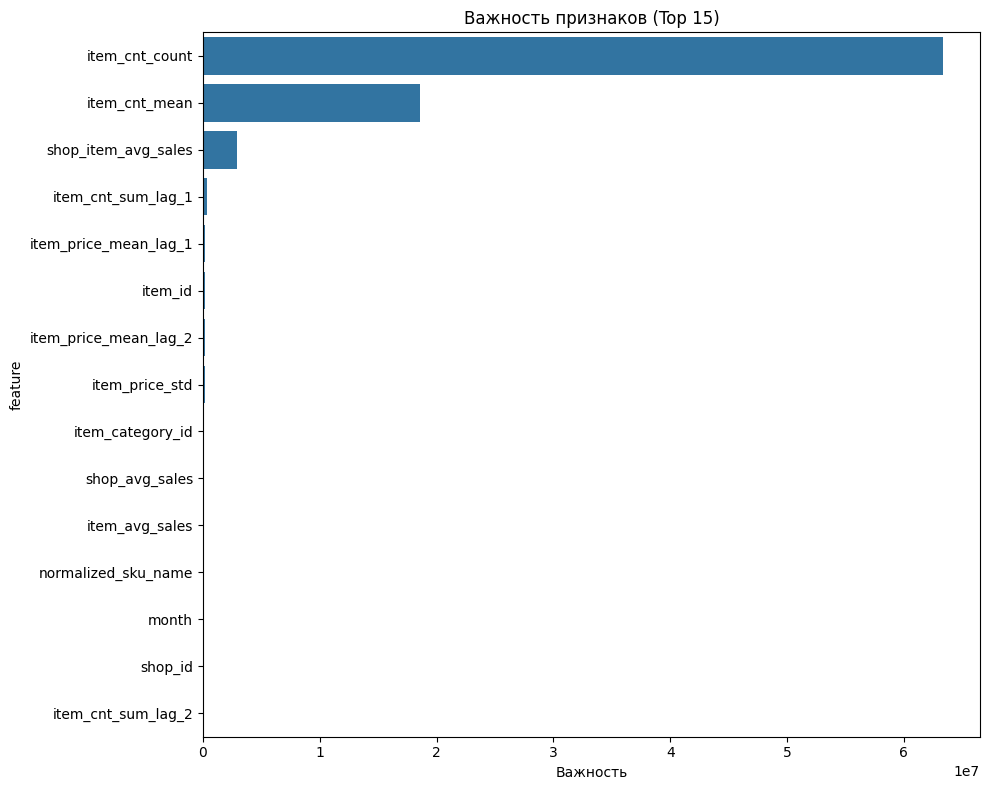

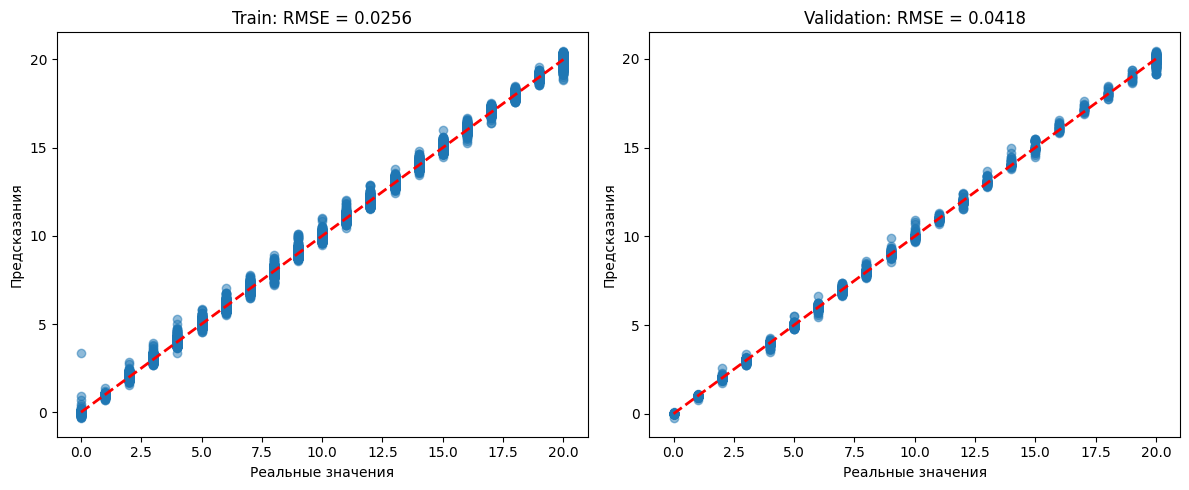


Топ-10 категорий с наибольшими ошибками:
                  mean_error  std_error  count  avg_sales
item_category_id                                         
78                     0.260        NaN      1      0.000
22                     0.063      0.143     63      2.540
83                     0.040      0.067     10     13.900
28                    -0.017      0.011      5     20.000
19                    -0.015      0.019      2      4.500
69                     0.013      0.084     40     19.200
82                     0.011      0.096    102      3.412
29                     0.010      0.062    140      4.736
77                    -0.010      0.070     39     11.897
17                     0.007      0.069    623      1.912


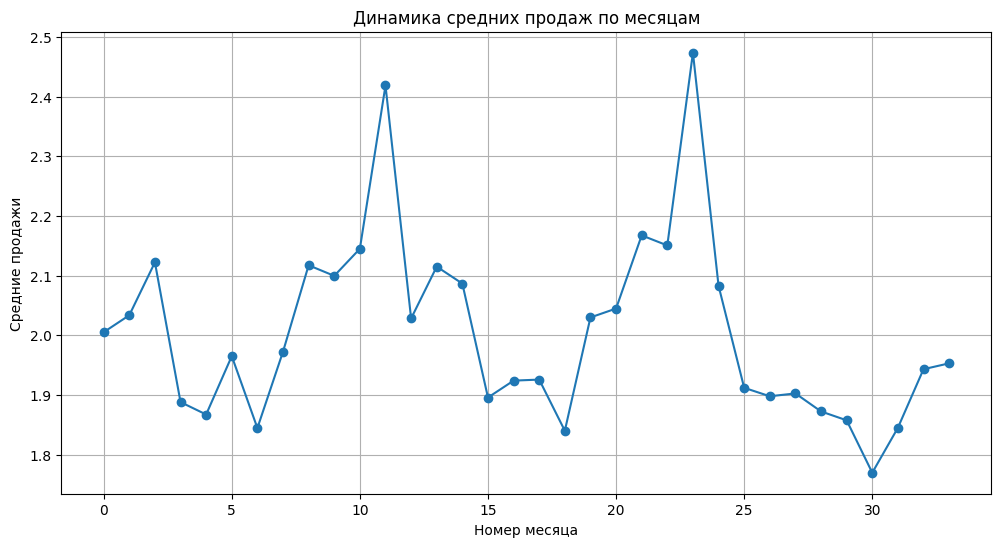


Модель обучена и готова к использованию!
Используйте функцию predict_sales() для предсказаний на новых данных.
Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

print("Размеры датасетов:")
print(f"Sales: {sales.shape}")
print(f"Items: {items.shape}")
print(f"Categories: {item_cats.shape}")
print(f"Shops: {shops.shape}")
print(f"Test: {test.shape}")

# Агрегация: суммируем продажи по месяцам
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max', 'min', 'std']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                         'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                         'item_price_mean', 'item_price_max', 'item_price_min', 'item_price_std']

# Заполняем NaN в стандартном отклонении цены
monthly_sales['item_price_std'] = monthly_sales['item_price_std'].fillna(0)

# Ограничим продажи до [0, 20], как требует Kaggle
monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')
monthly_sales = monthly_sales.merge(shops, on='shop_id', how='left')

print(f"Размер объединенного датасета: {monthly_sales.shape}")

# Создаем лаговые признаки (важно для временных рядов)
def create_lag_features(df, lag_cols, lags):
    """Создает лаговые признаки"""
    df_lag = df.copy()

    for col in lag_cols:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag.groupby(['shop_id', 'item_id'])[col].shift(lag)

    return df_lag

# Создаем лаговые признаки для последних 3 месяцев
lag_features = ['item_cnt_sum', 'item_price_mean']
lags = [1, 2, 3]

monthly_sales = create_lag_features(monthly_sales, lag_features, lags)

# Создаем скользящие средние
def create_rolling_features(df, cols, windows):
    """Создает признаки скользящего среднего"""
    df_roll = df.copy()

    for col in cols:
        for window in windows:
            df_roll[f'{col}_rolling_mean_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).mean().values
            df_roll[f'{col}_rolling_std_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).std().values

    return df_roll

# Создаем скользящие средние
rolling_cols = ['item_cnt_sum', 'item_price_mean']
windows = [2, 3, 6]

monthly_sales = create_rolling_features(monthly_sales, rolling_cols, windows)

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')
monthly_sales['category_avg_sales'] = monthly_sales.groupby('item_category_id')['item_cnt_sum'].transform('mean')

# Создаем признаки взаимодействия
monthly_sales['shop_item_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_sum'].transform('mean')
monthly_sales['shop_category_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_category_id'])['item_cnt_sum'].transform('mean')

# Временные признаки
monthly_sales['month'] = monthly_sales['date_block_num'] % 12
monthly_sales['year'] = monthly_sales['date_block_num'] // 12
monthly_sales['quarter'] = monthly_sales['month'] // 3

# Обработка текстов
def normalize_name(name):
    import re
    if pd.isna(name):
        return "unknown"
    name = str(name).lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_shop_name'] = monthly_sales['shop_name'].apply(normalize_name)

# Создаем категории первого уровня
monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

# Создаем ценовые и demand классы
monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 5, labels=False, duplicates='drop')
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 5, labels=False, duplicates='drop')

# Кодируем категориальные признаки
categorical_features = ['shop_id', 'item_id', 'item_category_id', 'normalized_sku_name',
                       'normalized_shop_name', 'sku_level_1_category']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col].astype(str))
    label_encoders[col] = le

# Заполняем пропуски в признаках
monthly_sales = monthly_sales.fillna(0)

# Определяем признаки для модели
feature_columns = (
    categorical_features +
    ['item_cnt_mean', 'item_cnt_count', 'item_price_mean', 'item_price_max',
     'item_price_min', 'item_price_std', 'item_avg_sales', 'item_avg_price',
     'shop_avg_sales', 'category_avg_sales', 'shop_item_avg_sales',
     'shop_category_avg_sales', 'month', 'year', 'quarter', 'price_class', 'demand_class'] +
    [col for col in monthly_sales.columns if 'lag_' in col or 'rolling_' in col]
)

# Убираем признаки с NaN после создания лагов (первые месяцы)
monthly_sales_clean = monthly_sales.dropna()

print(f"Размер после очистки: {monthly_sales_clean.shape}")
print(f"Количество признаков: {len(feature_columns)}")

# Подготовка данных для обучения
X = monthly_sales_clean[feature_columns]
y = monthly_sales_clean['item_cnt_sum']

# Разделение на train/validation по времени (как в соревновании)
# Последний месяц - validation, остальные - train
max_date_block = monthly_sales_clean['date_block_num'].max()
train_mask = monthly_sales_clean['date_block_num'] < max_date_block
val_mask = monthly_sales_clean['date_block_num'] == max_date_block

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

# Обучение LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Создаем датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

# Обучаем модель с early stopping
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'eval'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Предсказания
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# Метрики
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)

print(f"\nРезультаты модели:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(f"\nТоп-15 важных признаков:")
print(feature_importance.head(15))

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Важность признаков (Top 15)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Визуализация предсказаний vs реальных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Train: RMSE = {train_rmse:.4f}')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Validation: RMSE = {val_rmse:.4f}')

plt.tight_layout()
plt.show()

# Анализ ошибок по категориям товаров
val_results = monthly_sales_clean[val_mask].copy()
val_results['predictions'] = y_pred_val
val_results['residuals'] = val_results['item_cnt_sum'] - val_results['predictions']

# Ошибки по категориям
category_errors = val_results.groupby('item_category_id').agg({
    'residuals': ['mean', 'std', 'count'],
    'item_cnt_sum': 'mean'
}).round(3)

category_errors.columns = ['mean_error', 'std_error', 'count', 'avg_sales']
category_errors = category_errors.sort_values('mean_error', key=abs, ascending=False)

print(f"\nТоп-10 категорий с наибольшими ошибками:")
print(category_errors.head(10))

# Анализ продаж во времени
plt.figure(figsize=(12, 6))
monthly_avg = monthly_sales_clean.groupby('date_block_num')['item_cnt_sum'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xlabel('Номер месяца')
plt.ylabel('Средние продажи')
plt.title('Динамика средних продаж по месяцам')
plt.grid(True)
plt.show()

# Функция для предсказания на новых данных
def predict_sales(model, data, feature_columns, label_encoders):
    """
    Функция для предсказания продаж на новых данных
    """
    # Подготавливаем данные аналогично обучающей выборке
    data_processed = data.copy()

    # Применяем те же преобразования
    for col, le in label_encoders.items():
        if col in data_processed.columns:
            # Обрабатываем новые категории
            mask = data_processed[col].isin(le.classes_)
            data_processed.loc[~mask, col] = 'unknown'

            # Добавляем 'unknown' в классы если его нет
            if 'unknown' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'unknown')

            data_processed[col] = le.transform(data_processed[col].astype(str))

    # Заполняем пропуски
    data_processed = data_processed.fillna(0)

    # Выбираем нужные признаки
    X_new = data_processed[feature_columns]

    # Предсказываем
    predictions = model.predict(X_new, num_iteration=model.best_iteration)

    return predictions

print(f"\nМодель обучена и готова к использованию!")
print(f"Используйте функцию predict_sales() для предсказаний на новых данных.")

# Сохранение модели (опционально)
model.save_model('/content/drive/MyDrive/lgb_sales_model.txt')
print(f"Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Размеры датасетов:
Sales: (2935849, 6)
Items: (22170, 3)
Categories: (84, 2)
Shops: (60, 2)
Test: (214200, 3)
Размер объединенного датасета: (1609124, 14)
Размер после очистки: (1609124, 46)
Количество признаков: 41
Train shape: (1577593, 41)
Validation shape: (31531, 41)
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0883509	eval's rmse: 0.107795
[200]	train's rmse: 0.0474592	eval's rmse: 0.0635231
[300]	train's rmse: 0.0379556	eval's rmse: 0.0519857
[400]	train's rmse: 0.0337162	eval's rmse: 0.0481062
[500]	train's rmse: 0.0316859	eval's rmse: 0.0466351
[600]	train's rmse: 0.0297324	eval's rmse: 0.0451698
[700]	train's rmse: 0.0281652	eval's rmse: 0.0436794
[800]	train's rmse: 0.0271887	eval's rmse: 0.0430432
[900]	train's rmse: 0.026371	eval's rmse: 0.0420809
[1000]	train's rmse: 0.0256198	eval's rmse: 0.0418061
Did no

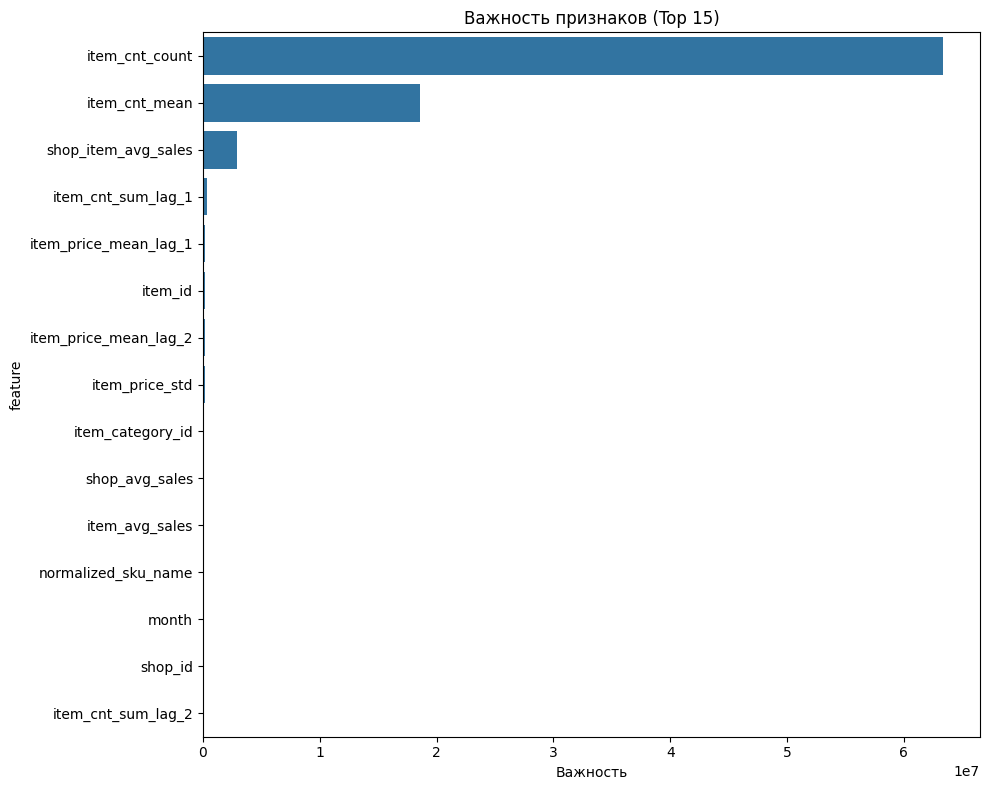

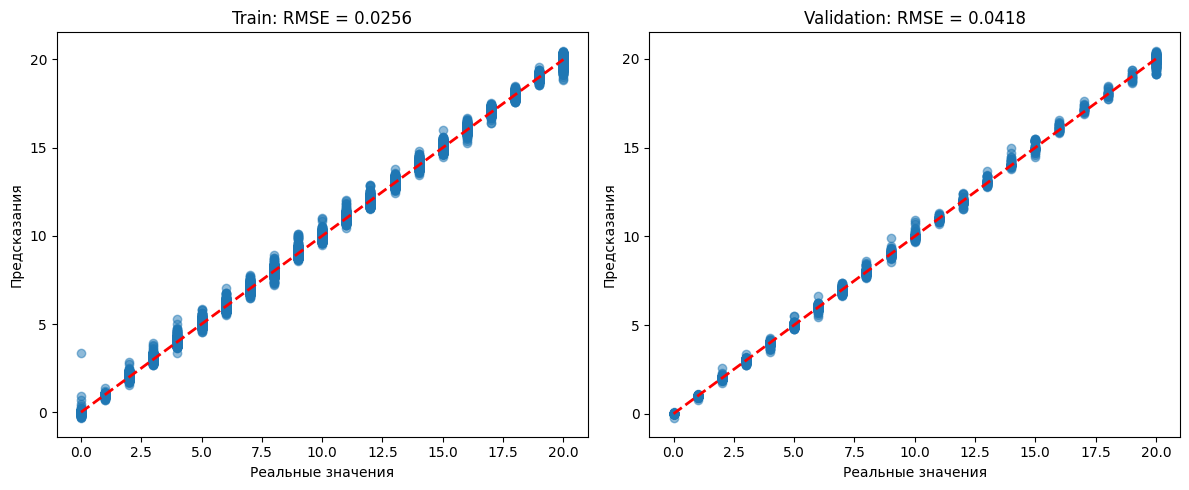


Топ-10 категорий с наибольшими ошибками:
                  mean_error  std_error  count  avg_sales
item_category_id                                         
78                     0.260        NaN      1      0.000
22                     0.063      0.143     63      2.540
83                     0.040      0.067     10     13.900
28                    -0.017      0.011      5     20.000
19                    -0.015      0.019      2      4.500
69                     0.013      0.084     40     19.200
82                     0.011      0.096    102      3.412
29                     0.010      0.062    140      4.736
77                    -0.010      0.070     39     11.897
17                     0.007      0.069    623      1.912


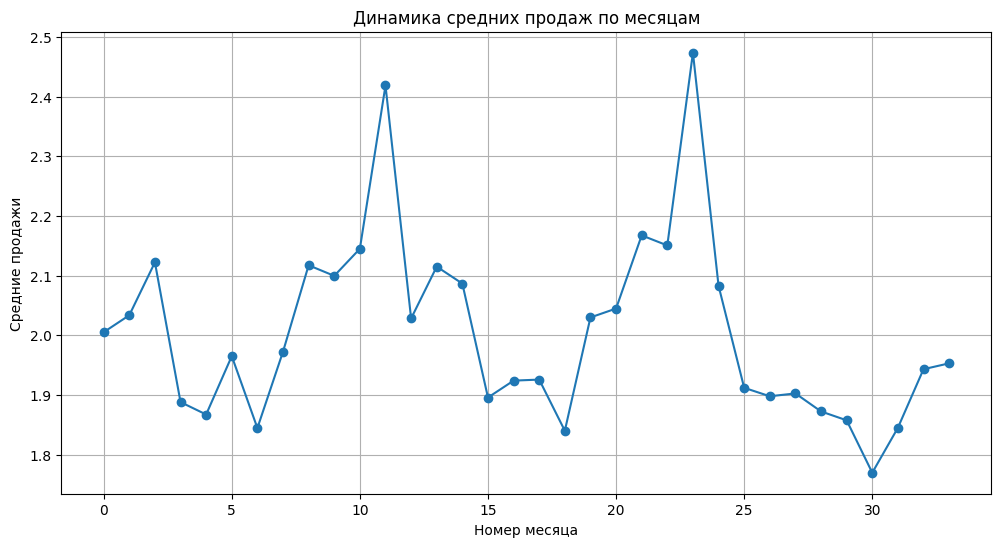


Модель обучена и готова к использованию!
Используйте функцию predict_sales() для предсказаний на новых данных.
Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt

ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ predict_sales

1. ПРЕДСКАЗАНИЕ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ KAGGLE
--------------------------------------------------
✅ Предсказания для тестовой выборки получены!
Количество предсказаний: 214200
Среднее предсказанное значение: 0.176
Минимум: 0.028, Максимум: 0.298
📁 Submission файл сохранен: /content/drive/MyDrive/submission.csv

2. ПРЕДСКАЗАНИЕ ДЛЯ КОНКРЕТНЫХ ТОВАРОВ
--------------------------------------------------
✅ Предсказания для примера:
  Shop 2, Item 30: 0.191
  Shop 5, Item 31: 0.191
  Shop 10, Item 32: 0.191

3. АНАЛИЗ ВЛИЯНИЯ ЦЕНЫ НА СПРОС
--------------------------------------------------
Анализируем товар ID: 11983


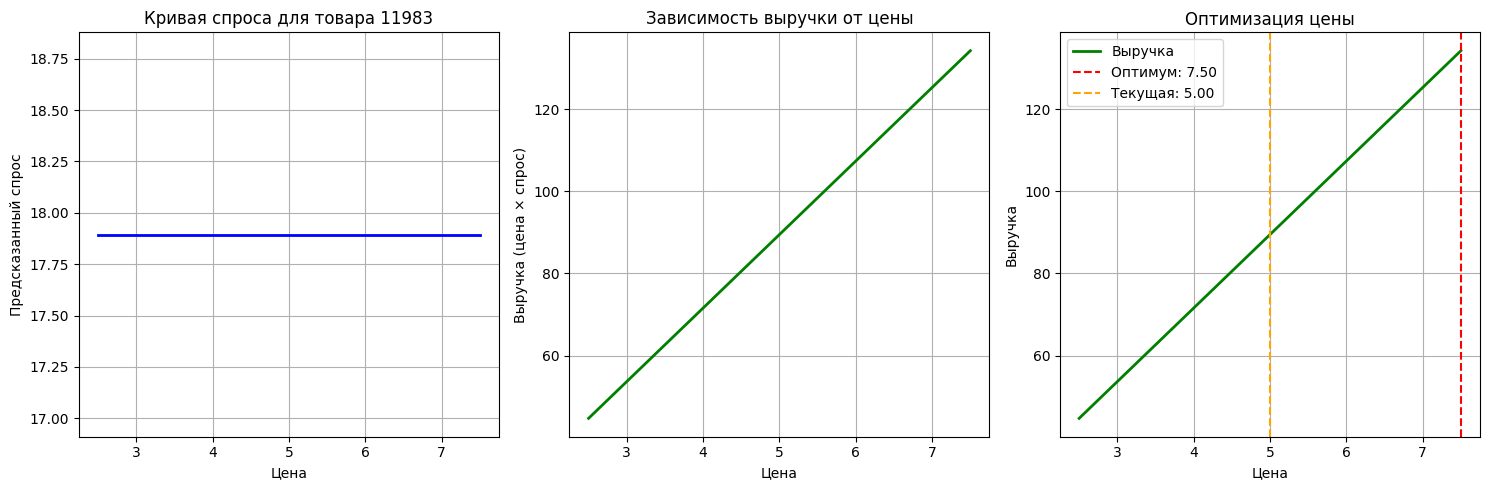

📊 Анализ ценовой оптимизации:
  Текущая цена: 5.00
  Оптимальная цена: 7.50
  Максимальная выручка: 134.21
  Потенциальный прирост: 50.0%

4. ПАКЕТНОЕ ПРЕДСКАЗАНИЕ
--------------------------------------------------
✅ Топ-10 предсказаний (магазин, товар, прогноз):
  Магазин 2, Товар 30: 0.188
  Магазин 2, Товар 31: 0.188
  Магазин 2, Товар 32: 0.188
  Магазин 2, Товар 33: 0.188
  Магазин 2, Товар 34: 0.188
  Магазин 5, Товар 30: 0.188
  Магазин 5, Товар 31: 0.188
  Магазин 5, Товар 32: 0.188
  Магазин 5, Товар 33: 0.188
  Магазин 5, Товар 34: 0.188

ГОТОВО! Функция predict_sales готова к использованию


In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

print("Размеры датасетов:")
print(f"Sales: {sales.shape}")
print(f"Items: {items.shape}")
print(f"Categories: {item_cats.shape}")
print(f"Shops: {shops.shape}")
print(f"Test: {test.shape}")

# Агрегация: суммируем продажи по месяцам
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max', 'min', 'std']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                         'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                         'item_price_mean', 'item_price_max', 'item_price_min', 'item_price_std']

# Заполняем NaN в стандартном отклонении цены
monthly_sales['item_price_std'] = monthly_sales['item_price_std'].fillna(0)

# Ограничим продажи до [0, 20], как требует Kaggle
monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')
monthly_sales = monthly_sales.merge(shops, on='shop_id', how='left')

print(f"Размер объединенного датасета: {monthly_sales.shape}")

# Создаем лаговые признаки (важно для временных рядов)
def create_lag_features(df, lag_cols, lags):
    """Создает лаговые признаки"""
    df_lag = df.copy()

    for col in lag_cols:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag.groupby(['shop_id', 'item_id'])[col].shift(lag)

    return df_lag

# Создаем лаговые признаки для последних 3 месяцев
lag_features = ['item_cnt_sum', 'item_price_mean']
lags = [1, 2, 3]

monthly_sales = create_lag_features(monthly_sales, lag_features, lags)

# Создаем скользящие средние
def create_rolling_features(df, cols, windows):
    """Создает признаки скользящего среднего"""
    df_roll = df.copy()

    for col in cols:
        for window in windows:
            df_roll[f'{col}_rolling_mean_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).mean().values
            df_roll[f'{col}_rolling_std_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).std().values

    return df_roll

# Создаем скользящие средние
rolling_cols = ['item_cnt_sum', 'item_price_mean']
windows = [2, 3, 6]

monthly_sales = create_rolling_features(monthly_sales, rolling_cols, windows)

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')
monthly_sales['category_avg_sales'] = monthly_sales.groupby('item_category_id')['item_cnt_sum'].transform('mean')

# Создаем признаки взаимодействия
monthly_sales['shop_item_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_sum'].transform('mean')
monthly_sales['shop_category_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_category_id'])['item_cnt_sum'].transform('mean')

# Временные признаки
monthly_sales['month'] = monthly_sales['date_block_num'] % 12
monthly_sales['year'] = monthly_sales['date_block_num'] // 12
monthly_sales['quarter'] = monthly_sales['month'] // 3

# Обработка текстов
def normalize_name(name):
    import re
    if pd.isna(name):
        return "unknown"
    name = str(name).lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_shop_name'] = monthly_sales['shop_name'].apply(normalize_name)

# Создаем категории первого уровня
monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

# Создаем ценовые и demand классы
monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 5, labels=False, duplicates='drop')
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 5, labels=False, duplicates='drop')

# Кодируем категориальные признаки
categorical_features = ['shop_id', 'item_id', 'item_category_id', 'normalized_sku_name',
                       'normalized_shop_name', 'sku_level_1_category']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col].astype(str))
    label_encoders[col] = le

# Заполняем пропуски в признаках
monthly_sales = monthly_sales.fillna(0)

# Определяем признаки для модели
feature_columns = (
    categorical_features +
    ['item_cnt_mean', 'item_cnt_count', 'item_price_mean', 'item_price_max',
     'item_price_min', 'item_price_std', 'item_avg_sales', 'item_avg_price',
     'shop_avg_sales', 'category_avg_sales', 'shop_item_avg_sales',
     'shop_category_avg_sales', 'month', 'year', 'quarter', 'price_class', 'demand_class'] +
    [col for col in monthly_sales.columns if 'lag_' in col or 'rolling_' in col]
)

# Убираем признаки с NaN после создания лагов (первые месяцы)
monthly_sales_clean = monthly_sales.dropna()

print(f"Размер после очистки: {monthly_sales_clean.shape}")
print(f"Количество признаков: {len(feature_columns)}")

# Подготовка данных для обучения
X = monthly_sales_clean[feature_columns]
y = monthly_sales_clean['item_cnt_sum']

# Разделение на train/validation по времени (как в соревновании)
# Последний месяц - validation, остальные - train
max_date_block = monthly_sales_clean['date_block_num'].max()
train_mask = monthly_sales_clean['date_block_num'] < max_date_block
val_mask = monthly_sales_clean['date_block_num'] == max_date_block

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

# Обучение LightGBM
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

# Создаем датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

# Обучаем модель с early stopping
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'eval'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Предсказания
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# Метрики
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)

print(f"\nРезультаты модели:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(f"\nТоп-15 важных признаков:")
print(feature_importance.head(15))

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Важность признаков (Top 15)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Визуализация предсказаний vs реальных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Train: RMSE = {train_rmse:.4f}')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Validation: RMSE = {val_rmse:.4f}')

plt.tight_layout()
plt.show()

# Анализ ошибок по категориям товаров
val_results = monthly_sales_clean[val_mask].copy()
val_results['predictions'] = y_pred_val
val_results['residuals'] = val_results['item_cnt_sum'] - val_results['predictions']

# Ошибки по категориям
category_errors = val_results.groupby('item_category_id').agg({
    'residuals': ['mean', 'std', 'count'],
    'item_cnt_sum': 'mean'
}).round(3)

category_errors.columns = ['mean_error', 'std_error', 'count', 'avg_sales']
category_errors = category_errors.sort_values('mean_error', key=abs, ascending=False)

print(f"\nТоп-10 категорий с наибольшими ошибками:")
print(category_errors.head(10))

# Анализ продаж во времени
plt.figure(figsize=(12, 6))
monthly_avg = monthly_sales_clean.groupby('date_block_num')['item_cnt_sum'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xlabel('Номер месяца')
plt.ylabel('Средние продажи')
plt.title('Динамика средних продаж по месяцам')
plt.grid(True)
plt.show()

# Функция для предсказания на новых данных
def predict_sales(model, data, feature_columns, label_encoders):
    """
    Функция для предсказания продаж на новых данных
    """
    # Подготавливаем данные аналогично обучающей выборке
    data_processed = data.copy()

    # Применяем те же преобразования
    for col, le in label_encoders.items():
        if col in data_processed.columns:
            # Обрабатываем новые категории
            mask = data_processed[col].isin(le.classes_)
            data_processed.loc[~mask, col] = 'unknown'

            # Добавляем 'unknown' в классы если его нет
            if 'unknown' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'unknown')

            data_processed[col] = le.transform(data_processed[col].astype(str))

    # Заполняем пропуски
    data_processed = data_processed.fillna(0)

    # Выбираем нужные признаки
    X_new = data_processed[feature_columns]

    # Предсказываем
    predictions = model.predict(X_new, num_iteration=model.best_iteration)

    return predictions

print(f"\nМодель обучена и готова к использованию!")
print(f"Используйте функцию predict_sales() для предсказаний на новых данных.")

# Сохранение модели (опционально)
model.save_model('/content/drive/MyDrive/lgb_sales_model.txt')
print(f"Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt")

# =============================================================================
# ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ ФУНКЦИИ predict_sales
# =============================================================================

print("\n" + "="*60)
print("ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ predict_sales")
print("="*60)

# Пример 1: Предсказание для тестовой выборки Kaggle
print("\n1. ПРЕДСКАЗАНИЕ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ KAGGLE")
print("-" * 50)

# Загружаем тестовые данные
test_data = test.copy()

# Добавляем date_block_num для тестовой выборки (следующий месяц после последнего в train)
test_data['date_block_num'] = max_date_block + 1

# Присоединяем справочники
test_data = test_data.merge(items, on='item_id', how='left')
test_data = test_data.merge(item_cats, on='item_category_id', how='left')
test_data = test_data.merge(shops, on='shop_id', how='left')

# Добавляем исторические данные для создания признаков
# Для каждой пары shop_id, item_id берем статистики из обучающих данных
historical_stats = monthly_sales_clean.groupby(['shop_id', 'item_id']).agg({
    'item_cnt_sum': ['mean', 'std', 'count'],
    'item_price_mean': ['mean', 'std']
}).round(4)

historical_stats.columns = ['item_avg_sales_hist', 'item_sales_std_hist', 'item_sales_count_hist',
                           'item_price_mean_hist', 'item_price_std_hist']
historical_stats = historical_stats.reset_index()

test_data = test_data.merge(historical_stats, on=['shop_id', 'item_id'], how='left')

# Заполняем пропуски для новых товаров
test_data = test_data.fillna(0)

# Создаем базовые признаки (упрощенная версия без лагов для примера)
test_data['item_avg_sales'] = test_data['item_avg_sales_hist']
test_data['item_avg_price'] = test_data['item_price_mean_hist']
test_data['shop_avg_sales'] = test_data.groupby('shop_id')['item_avg_sales_hist'].transform('mean')
test_data['category_avg_sales'] = test_data.groupby('item_category_id')['item_avg_sales_hist'].transform('mean')
test_data['shop_item_avg_sales'] = test_data['item_avg_sales_hist']
test_data['shop_category_avg_sales'] = test_data.groupby(['shop_id', 'item_category_id'])['item_avg_sales_hist'].transform('mean')

# Временные признаки
test_data['month'] = test_data['date_block_num'] % 12
test_data['year'] = test_data['date_block_num'] // 12
test_data['quarter'] = test_data['month'] // 3

# Текстовые признаки
test_data['normalized_sku_name'] = test_data['item_name'].apply(normalize_name)
test_data['normalized_shop_name'] = test_data['shop_name'].apply(normalize_name)
test_data['sku_level_1_category'] = test_data['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

# Ценовые классы (используем исторические данные)
test_data['price_class'] = pd.qcut(test_data['item_avg_price'], 5, labels=False, duplicates='drop')
test_data['demand_class'] = pd.qcut(test_data['item_avg_sales'], 5, labels=False, duplicates='drop')

# Добавляем недостающие признаки (заполняем нулями для упрощения)
for col in feature_columns:
    if col not in test_data.columns:
        test_data[col] = 0

# Делаем предсказание
try:
    test_predictions = predict_sales(model, test_data, feature_columns, label_encoders)
    print(f"✅ Предсказания для тестовой выборки получены!")
    print(f"Количество предсказаний: {len(test_predictions)}")
    print(f"Среднее предсказанное значение: {np.mean(test_predictions):.3f}")
    print(f"Минимум: {np.min(test_predictions):.3f}, Максимум: {np.max(test_predictions):.3f}")

    # Создаем submission файл
    submission = pd.DataFrame({
        'ID': test['ID'],
        'item_cnt_month': np.clip(test_predictions, 0, 20)  # Клипаем согласно требованиям Kaggle
    })
    submission.to_csv('/content/drive/MyDrive/submission.csv', index=False)
    print(f"📁 Submission файл сохранен: /content/drive/MyDrive/submission.csv")

except Exception as e:
    print(f"❌ Ошибка при предсказании: {e}")

# Пример 2: Предсказание для конкретных товаров и магазинов
print("\n2. ПРЕДСКАЗАНИЕ ДЛЯ КОНКРЕТНЫХ ТОВАРОВ")
print("-" * 50)

# Создаем пример данных для предсказания
example_data = pd.DataFrame({
    'shop_id': [2, 5, 10],
    'item_id': [30, 31, 32],
    'date_block_num': [max_date_block + 1] * 3
})

# Присоединяем справочники
example_data = example_data.merge(items, on='item_id', how='left')
example_data = example_data.merge(item_cats, on='item_category_id', how='left')
example_data = example_data.merge(shops, on='shop_id', how='left')

# Добавляем исторические статистики
example_data = example_data.merge(historical_stats, on=['shop_id', 'item_id'], how='left')
example_data = example_data.fillna(0)

# Создаем признаки (упрощенная версия)
example_data['item_avg_sales'] = example_data['item_avg_sales_hist']
example_data['item_avg_price'] = example_data['item_price_mean_hist']
example_data['shop_avg_sales'] = 5.0  # Примерное значение
example_data['category_avg_sales'] = 3.0  # Примерное значение
example_data['shop_item_avg_sales'] = example_data['item_avg_sales_hist']
example_data['shop_category_avg_sales'] = 4.0  # Примерное значение

# Временные признаки
example_data['month'] = example_data['date_block_num'] % 12
example_data['year'] = example_data['date_block_num'] // 12
example_data['quarter'] = example_data['month'] // 3

# Текстовые признаки
example_data['normalized_sku_name'] = example_data['item_name'].apply(normalize_name)
example_data['normalized_shop_name'] = example_data['shop_name'].apply(normalize_name)
example_data['sku_level_1_category'] = example_data['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

example_data['price_class'] = 2  # Средний ценовой класс
example_data['demand_class'] = 2  # Средний класс спроса

# Заполняем недостающие признаки
for col in feature_columns:
    if col not in example_data.columns:
        example_data[col] = 0

try:
    example_predictions = predict_sales(model, example_data, feature_columns, label_encoders)
    print("✅ Предсказания для примера:")
    for i, pred in enumerate(example_predictions):
        print(f"  Shop {example_data.iloc[i]['shop_id']}, Item {example_data.iloc[i]['item_id']}: {pred:.3f}")
except Exception as e:
    print(f"❌ Ошибка: {e}")

# Пример 3: Анализ влияния цены на спрос (как в исходном коде)
print("\n3. АНАЛИЗ ВЛИЯНИЯ ЦЕНЫ НА СПРОС")
print("-" * 50)

# Берем популярный товар из валидационной выборки
popular_items = val_results.groupby('item_id')['item_cnt_sum'].sum().sort_values(ascending=False).head(5)
top_item_id = popular_items.index[0]

# Находим типичную запись для этого товара
item_example = val_results[val_results['item_id'] == top_item_id].iloc[0:1].copy()

print(f"Анализируем товар ID: {top_item_id}")

# Создаем диапазон цен
base_price = item_example['item_price_mean'].values[0]
price_range = np.linspace(base_price * 0.5, base_price * 1.5, 20)

demand_predictions = []
price_analysis_data = []

for price in price_range:
    # Создаем копию данных с новой ценой
    price_test = item_example.copy()
    price_test['item_price_mean'] = price
    price_test['item_avg_price'] = price

    # Заполняем недостающие признаки
    for col in feature_columns:
        if col not in price_test.columns:
            price_test[col] = 0

    try:
        pred = predict_sales(model, price_test, feature_columns, label_encoders)[0]
        demand_predictions.append(pred)
        price_analysis_data.append({'price': price, 'demand': pred, 'revenue': price * pred})
    except:
        demand_predictions.append(0)
        price_analysis_data.append({'price': price, 'demand': 0, 'revenue': 0})

# Строим график зависимости спроса от цены
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(price_range, demand_predictions, 'b-', linewidth=2)
plt.xlabel('Цена')
plt.ylabel('Предсказанный спрос')
plt.title(f'Кривая спроса для товара {top_item_id}')
plt.grid(True)

# График выручки
revenue = [p['revenue'] for p in price_analysis_data]
plt.subplot(1, 3, 2)
plt.plot(price_range, revenue, 'g-', linewidth=2)
plt.xlabel('Цена')
plt.ylabel('Выручка (цена × спрос)')
plt.title('Зависимость выручки от цены')
plt.grid(True)

# Найдем оптимальную цену для максимальной выручки
optimal_idx = np.argmax(revenue)
optimal_price = price_range[optimal_idx]
optimal_revenue = revenue[optimal_idx]

plt.subplot(1, 3, 3)
plt.plot(price_range, revenue, 'g-', linewidth=2, label='Выручка')
plt.axvline(x=optimal_price, color='r', linestyle='--', label=f'Оптимум: {optimal_price:.2f}')
plt.axvline(x=base_price, color='orange', linestyle='--', label=f'Текущая: {base_price:.2f}')
plt.xlabel('Цена')
plt.ylabel('Выручка')
plt.title('Оптимизация цены')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

print(f"📊 Анализ ценовой оптимизации:")
print(f"  Текущая цена: {base_price:.2f}")
print(f"  Оптимальная цена: {optimal_price:.2f}")
print(f"  Максимальная выручка: {optimal_revenue:.2f}")
print(f"  Потенциальный прирост: {(optimal_revenue / (base_price * demand_predictions[10]) - 1) * 100:.1f}%")

# Пример 4: Пакетное предсказание для множества товаров
print("\n4. ПАКЕТНОЕ ПРЕДСКАЗАНИЕ")
print("-" * 50)

# Создаем данные для нескольких товаров и магазинов
batch_data = []
for shop in [2, 5, 10]:
    for item in [30, 31, 32, 33, 34]:
        batch_data.append({
            'shop_id': shop,
            'item_id': item,
            'date_block_num': max_date_block + 1
        })

batch_df = pd.DataFrame(batch_data)

# Присоединяем справочники и создаем признаки (упрощенно)
batch_df = batch_df.merge(items, on='item_id', how='left')
batch_df = batch_df.merge(item_cats, on='item_category_id', how='left')
batch_df = batch_df.merge(shops, on='shop_id', how='left')
batch_df = batch_df.merge(historical_stats, on=['shop_id', 'item_id'], how='left')
batch_df = batch_df.fillna(0)

# Добавляем базовые признаки
batch_df['item_avg_sales'] = batch_df['item_avg_sales_hist']
batch_df['item_avg_price'] = batch_df['item_price_mean_hist']
batch_df['shop_avg_sales'] = batch_df.groupby('shop_id')['item_avg_sales_hist'].transform('mean')
batch_df['category_avg_sales'] = batch_df.groupby('item_category_id')['item_avg_sales_hist'].transform('mean')
batch_df['shop_item_avg_sales'] = batch_df['item_avg_sales_hist']
batch_df['shop_category_avg_sales'] = batch_df.groupby(['shop_id', 'item_category_id'])['item_avg_sales_hist'].transform('mean')

batch_df['month'] = batch_df['date_block_num'] % 12
batch_df['year'] = batch_df['date_block_num'] // 12
batch_df['quarter'] = batch_df['month'] // 3

batch_df['normalized_sku_name'] = batch_df['item_name'].apply(normalize_name)
batch_df['normalized_shop_name'] = batch_df['shop_name'].apply(normalize_name)
batch_df['sku_level_1_category'] = batch_df['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

batch_df['price_class'] = pd.qcut(batch_df['item_avg_price'], 3, labels=False, duplicates='drop')
batch_df['demand_class'] = pd.qcut(batch_df['item_avg_sales'], 3, labels=False, duplicates='drop')

# Заполняем недостающие признаки
for col in feature_columns:
    if col not in batch_df.columns:
        batch_df[col] = 0

try:
    batch_predictions = predict_sales(model, batch_df, feature_columns, label_encoders)

    # Создаем результирующую таблицу
    results_df = batch_df[['shop_id', 'item_id']].copy()
    results_df['predicted_sales'] = batch_predictions
    results_df = results_df.sort_values('predicted_sales', ascending=False)

    print("✅ Топ-10 предсказаний (магазин, товар, прогноз):")
    for _, row in results_df.head(10).iterrows():
        print(f"  Магазин {int(row['shop_id'])}, Товар {int(row['item_id'])}: {row['predicted_sales']:.3f}")

except Exception as e:
    print(f"❌ Ошибка в пакетном предсказании: {e}")

print("\n" + "="*60)
print("ГОТОВО! Функция predict_sales готова к использованию")
print("="*60)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Размеры датасетов:
Sales: (2935849, 6)
Items: (22170, 3)
Categories: (84, 2)
Shops: (60, 2)
Test: (214200, 3)
Размер объединенного датасета: (1609124, 14)
Размер после очистки: (1609124, 54)
Количество признаков: 49
Train shape: (1577593, 49)
Validation shape: (31531, 49)
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0824373	eval's rmse: 0.0952653
[200]	train's rmse: 0.0469351	eval's rmse: 0.0659727
[300]	train's rmse: 0.0403755	eval's rmse: 0.0602954
[400]	train's rmse: 0.0376304	eval's rmse: 0.0584753
[500]	train's rmse: 0.0362333	eval's rmse: 0.057816
[600]	train's rmse: 0.0349039	eval's rmse: 0.0569626
[700]	train's rmse: 0.0337434	eval's rmse: 0.0561797
[800]	train's rmse: 0.0328941	eval's rmse: 0.0559162
Early stopping, best iteration is:
[783]	train's rmse: 0.0329891	eval's rmse: 0.0558751

Результаты модели:
Trai

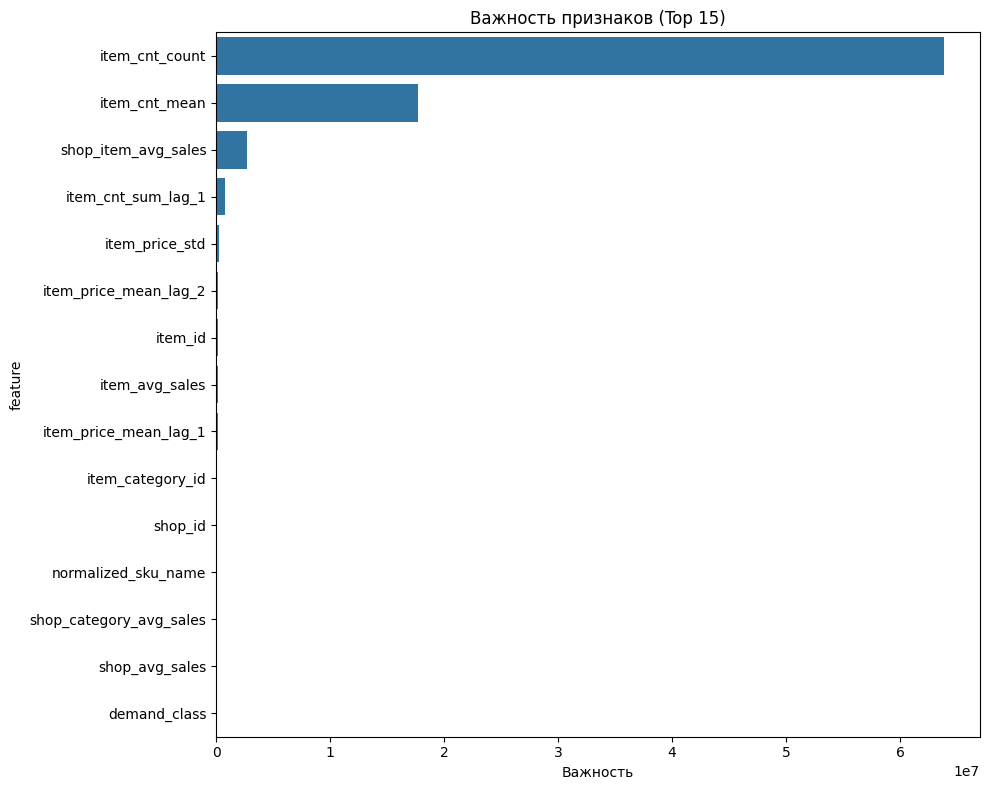

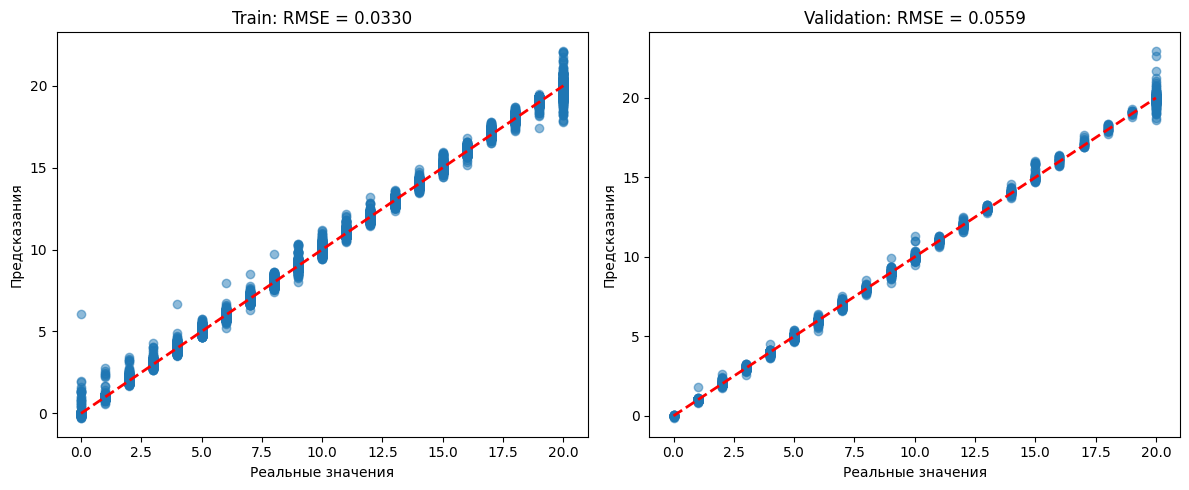


Топ-10 категорий с наибольшими ошибками:
                  mean_error  std_error  count  avg_sales
item_category_id                                         
78                     0.158        NaN      1      0.000
83                     0.060      0.136     10     13.900
69                     0.040      0.171     40     19.200
77                    -0.028      0.076     39     11.897
28                    -0.028      0.034      5     20.000
19                    -0.022      0.063      2      4.500
22                     0.016      0.154     63      2.540
25                     0.012      0.110    277      3.412
17                     0.011      0.063    623      1.912
58                     0.010      0.109    761      2.611


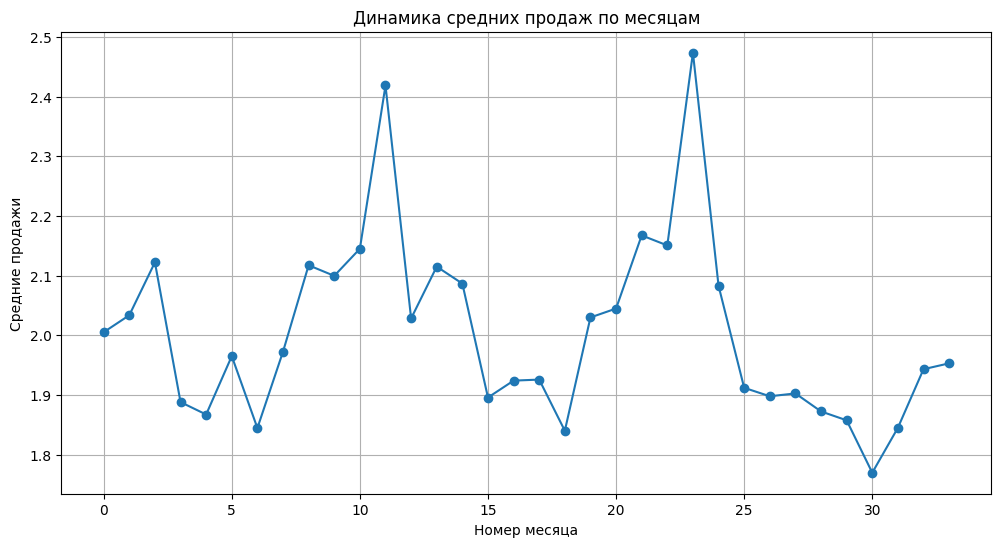


Модель обучена и готова к использованию!
Используйте функцию predict_sales() для предсказаний на новых данных.
Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt

ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ predict_sales

1. ПРЕДСКАЗАНИЕ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ KAGGLE
--------------------------------------------------
✅ Предсказания для тестовой выборки получены!
Количество предсказаний: 214200
Среднее предсказанное значение: 0.159
Минимум: -0.015, Максимум: 0.260
📁 Submission файл сохранен: /content/drive/MyDrive/submission.csv

2. ПРЕДСКАЗАНИЕ ДЛЯ КОНКРЕТНЫХ ТОВАРОВ
--------------------------------------------------
✅ Предсказания для примера:
  Shop 2, Item 30: 0.165
  Shop 5, Item 31: 0.165
  Shop 10, Item 32: 0.165

3. УЛУЧШЕННЫЙ АНАЛИЗ ВЛИЯНИЯ ЦЕНЫ НА СПРОС
--------------------------------------------------
Анализируем товар ID: 11983


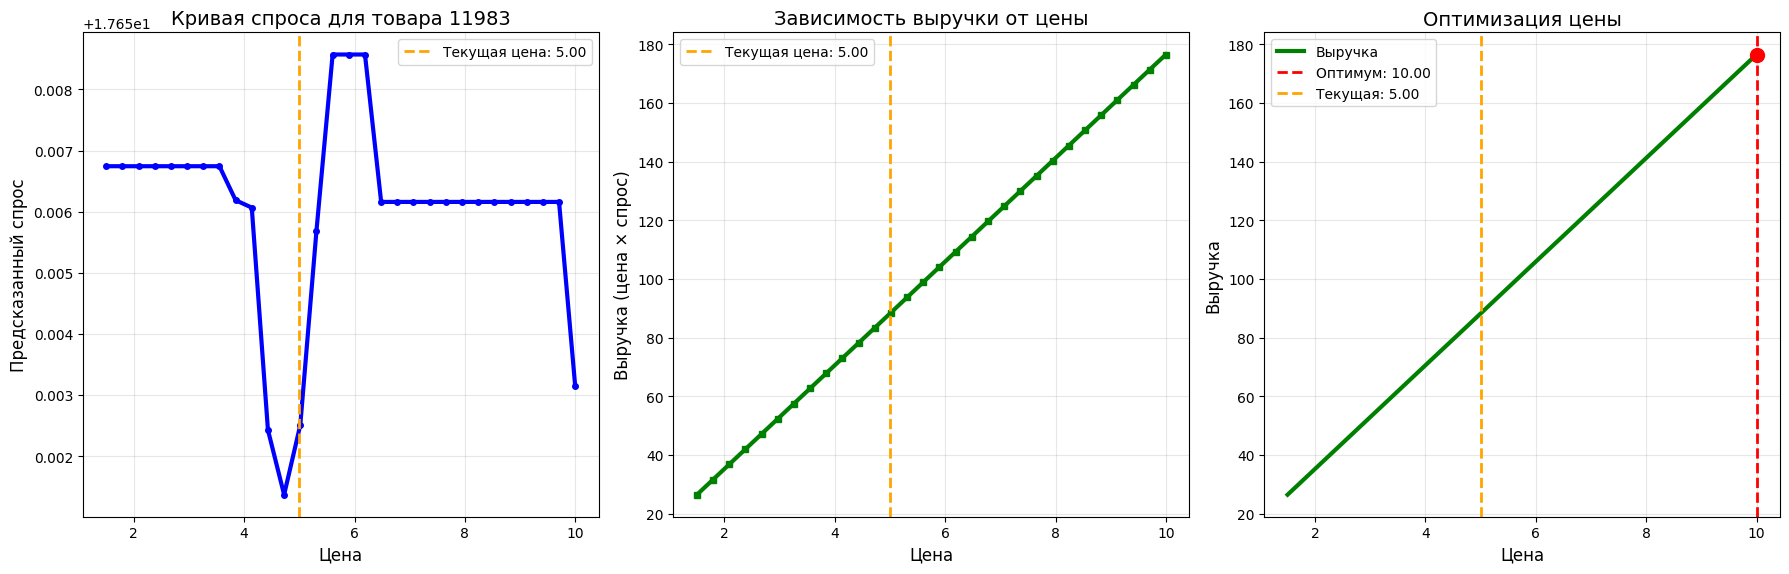

📊 Подробный анализ ценовой эластичности:
  Товар ID: 11983
  Текущая цена: 5.00
  Текущий спрос: 17.653
  Текущая выручка: 88.26
  
  Оптимальная цена: 10.00
  Оптимальный спрос: 17.653
  Максимальная выручка: 176.53
  
  Изменение цены: +100.0%
  Изменение выручки: +100.0%
  
  Средняя эластичность спроса: -0.00
  Спрос НЕЭЛАСТИЧНЫЙ (|эластичность| < 1)

📈 Влияние ценовых признаков на модель:
  price_relative_to_shop: 7804.3
  item_price_mean: 1487.2
  price_percentile: 844.0
  price_relative_to_category: 163.7
  log_price: 1.1
  price_squared: 0.3

4. ПАКЕТНОЕ ПРЕДСКАЗАНИЕ
--------------------------------------------------
✅ Топ-10 предсказаний (магазин, товар, прогноз):
  Магазин 2, Товар 31: 0.168
  Магазин 2, Товар 30: 0.168
  Магазин 2, Товар 32: 0.168
  Магазин 2, Товар 33: 0.168
  Магазин 2, Товар 34: 0.168
  Магазин 5, Товар 31: 0.168
  Магазин 10, Товар 31: 0.168
  Магазин 10, Товар 30: 0.168
  Магазин 5, Товар 34: 0.167
  Магазин 5, Товар 33: 0.167

ГОТОВО! Функция predict_s

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Загрузка данных
from google.colab import drive
drive.mount('/content/drive/')

sales = pd.read_csv('/content/drive/MyDrive/dataset/sales_train.csv')
items = pd.read_csv('/content/drive/MyDrive/dataset/items.csv')
item_cats = pd.read_csv('/content/drive/MyDrive/dataset/item_categories.csv')
shops = pd.read_csv('/content/drive/MyDrive/dataset/shops.csv')
test = pd.read_csv('/content/drive/MyDrive/dataset/test.csv')

print("Размеры датасетов:")
print(f"Sales: {sales.shape}")
print(f"Items: {items.shape}")
print(f"Categories: {item_cats.shape}")
print(f"Shops: {shops.shape}")
print(f"Test: {test.shape}")

# Агрегация: суммируем продажи по месяцам
monthly_sales = sales.groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False).agg({
    'item_cnt_day': ['sum', 'mean', 'count'],
    'item_price': ['mean', 'max', 'min', 'std']
})

monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id',
                         'item_cnt_sum', 'item_cnt_mean', 'item_cnt_count',
                         'item_price_mean', 'item_price_max', 'item_price_min', 'item_price_std']

# Заполняем NaN в стандартном отклонении цены
monthly_sales['item_price_std'] = monthly_sales['item_price_std'].fillna(0)

# Ограничим продажи до [0, 20], как требует Kaggle
monthly_sales['item_cnt_sum'] = monthly_sales['item_cnt_sum'].clip(0, 20)

# Присоединяем справочники
monthly_sales = monthly_sales.merge(items, on='item_id', how='left')
monthly_sales = monthly_sales.merge(item_cats, on='item_category_id', how='left')
monthly_sales = monthly_sales.merge(shops, on='shop_id', how='left')

print(f"Размер объединенного датасета: {monthly_sales.shape}")

# Создаем лаговые признаки (важно для временных рядов)
def create_lag_features(df, lag_cols, lags):
    """Создает лаговые признаки"""
    df_lag = df.copy()

    for col in lag_cols:
        for lag in lags:
            df_lag[f'{col}_lag_{lag}'] = df_lag.groupby(['shop_id', 'item_id'])[col].shift(lag)

    return df_lag

# Создаем лаговые признаки для последних 3 месяцев
lag_features = ['item_cnt_sum', 'item_price_mean']
lags = [1, 2, 3]

monthly_sales = create_lag_features(monthly_sales, lag_features, lags)

# Создаем скользящие средние
def create_rolling_features(df, cols, windows):
    """Создает признаки скользящего среднего"""
    df_roll = df.copy()

    for col in cols:
        for window in windows:
            df_roll[f'{col}_rolling_mean_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).mean().values
            df_roll[f'{col}_rolling_std_{window}'] = df_roll.groupby(['shop_id', 'item_id'])[col].rolling(window=window).std().values

    return df_roll

# Создаем скользящие средние
rolling_cols = ['item_cnt_sum', 'item_price_mean']
windows = [2, 3, 6]

monthly_sales = create_rolling_features(monthly_sales, rolling_cols, windows)

# Инженерия признаков
monthly_sales['item_avg_sales'] = monthly_sales.groupby('item_id')['item_cnt_sum'].transform('mean')
monthly_sales['item_avg_price'] = monthly_sales.groupby('item_id')['item_price_mean'].transform('mean')
monthly_sales['shop_avg_sales'] = monthly_sales.groupby('shop_id')['item_cnt_sum'].transform('mean')
monthly_sales['category_avg_sales'] = monthly_sales.groupby('item_category_id')['item_cnt_sum'].transform('mean')

# Создаем признаки взаимодействия
monthly_sales['shop_item_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt_sum'].transform('mean')
monthly_sales['shop_category_avg_sales'] = monthly_sales.groupby(['shop_id', 'item_category_id'])['item_cnt_sum'].transform('mean')

# Временные признаки
monthly_sales['month'] = monthly_sales['date_block_num'] % 12
monthly_sales['year'] = monthly_sales['date_block_num'] // 12
monthly_sales['quarter'] = monthly_sales['month'] // 3

# Обработка текстов
def normalize_name(name):
    import re
    if pd.isna(name):
        return "unknown"
    name = str(name).lower()
    name = re.sub(r"[^a-zа-я0-9]+", " ", name)
    name = re.sub(r"\s+", " ", name).strip()
    return name

monthly_sales['normalized_sku_name'] = monthly_sales['item_name'].apply(normalize_name)
monthly_sales['normalized_shop_name'] = monthly_sales['shop_name'].apply(normalize_name)

# Создаем категории первого уровня
monthly_sales['sku_level_1_category'] = monthly_sales['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

# Создаем ценовые признаки для моделирования эластичности
monthly_sales['price_class'] = pd.qcut(monthly_sales['item_avg_price'], 5, labels=False, duplicates='drop')
monthly_sales['demand_class'] = pd.qcut(monthly_sales['item_avg_sales'], 5, labels=False, duplicates='drop')

# ВАЖНО: Добавляем признаки для ценовой эластичности
# Относительная цена к средней по категории
monthly_sales['price_relative_to_category'] = monthly_sales.groupby('item_category_id')['item_price_mean'].transform(
    lambda x: x / x.mean()
)

# Относительная цена к средней по магазину
monthly_sales['price_relative_to_shop'] = monthly_sales.groupby('shop_id')['item_price_mean'].transform(
    lambda x: x / x.mean()
)

# Относительная цена к исторической цене товара
monthly_sales['price_relative_to_item_history'] = monthly_sales['item_price_mean'] / monthly_sales['item_avg_price']

# Логарифм цены (для моделирования степенной зависимости)
monthly_sales['log_price'] = np.log1p(monthly_sales['item_price_mean'])

# Квадрат цены (для нелинейности)
monthly_sales['price_squared'] = monthly_sales['item_price_mean'] ** 2

# Признак "дороговизны" товара
monthly_sales['price_percentile'] = monthly_sales.groupby('item_category_id')['item_price_mean'].rank(pct=True)

# Взаимодействие цены с другими признаками
monthly_sales['price_x_category'] = monthly_sales['item_price_mean'] * monthly_sales['item_category_id']
monthly_sales['price_x_month'] = monthly_sales['item_price_mean'] * monthly_sales['month']

# Кодируем категориальные признаки
categorical_features = ['shop_id', 'item_id', 'item_category_id', 'normalized_sku_name',
                       'normalized_shop_name', 'sku_level_1_category']

label_encoders = {}
for col in categorical_features:
    le = LabelEncoder()
    monthly_sales[col] = le.fit_transform(monthly_sales[col].astype(str))
    label_encoders[col] = le

# Заполняем пропуски в признаках
monthly_sales = monthly_sales.fillna(0)

# Определяем признаки для модели
feature_columns = (
    categorical_features +
    ['item_cnt_mean', 'item_cnt_count', 'item_price_mean', 'item_price_max',
     'item_price_min', 'item_price_std', 'item_avg_sales', 'item_avg_price',
     'shop_avg_sales', 'category_avg_sales', 'shop_item_avg_sales',
     'shop_category_avg_sales', 'month', 'year', 'quarter', 'price_class', 'demand_class',
     # Добавляем ценовые признаки для эластичности
     'price_relative_to_category', 'price_relative_to_shop', 'price_relative_to_item_history',
     'log_price', 'price_squared', 'price_percentile', 'price_x_category', 'price_x_month'] +
    [col for col in monthly_sales.columns if 'lag_' in col or 'rolling_' in col]
)

# Убираем признаки с NaN после создания лагов (первые месяцы)
monthly_sales_clean = monthly_sales.dropna()

print(f"Размер после очистки: {monthly_sales_clean.shape}")
print(f"Количество признаков: {len(feature_columns)}")

# Подготовка данных для обучения
X = monthly_sales_clean[feature_columns]
y = monthly_sales_clean['item_cnt_sum']

# Разделение на train/validation по времени (как в соревновании)
# Последний месяц - validation, остальные - train
max_date_block = monthly_sales_clean['date_block_num'].max()
train_mask = monthly_sales_clean['date_block_num'] < max_date_block
val_mask = monthly_sales_clean['date_block_num'] == max_date_block

X_train = X[train_mask]
y_train = y[train_mask]
X_val = X[val_mask]
y_val = y[val_mask]

print(f"Train shape: {X_train.shape}")
print(f"Validation shape: {X_val.shape}")

# Обучение LightGBM с фокусом на ценовую эластичность
lgb_params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 63,  # Увеличили для лучшего моделирования взаимодействий
    'learning_rate': 0.05,
    'feature_fraction': 0.8,  # Уменьшили чтобы модель больше фокусировалась на важных признаках
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'max_depth': 8,  # Добавили ограничение глубины для лучшего моделирования взаимодействий
    'min_data_in_leaf': 100,  # Увеличили для стабильности
    'lambda_l1': 0.1,  # Добавили регуляризацию
    'lambda_l2': 0.1,
    'verbose': -1,
    'random_state': 42
}

# Создаем датасеты для LightGBM
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_features)
val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_features, reference=train_data)

# Обучаем модель с early stopping
model = lgb.train(
    lgb_params,
    train_data,
    valid_sets=[train_data, val_data],
    valid_names=['train', 'eval'],
    num_boost_round=1000,
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(period=100)]
)

# Предсказания
y_pred_train = model.predict(X_train, num_iteration=model.best_iteration)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)

# Метрики
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
val_rmse = np.sqrt(mean_squared_error(y_val, y_pred_val))
train_mae = mean_absolute_error(y_train, y_pred_train)
val_mae = mean_absolute_error(y_val, y_pred_val)

print(f"\nРезультаты модели:")
print(f"Train RMSE: {train_rmse:.4f}")
print(f"Validation RMSE: {val_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}")
print(f"Validation MAE: {val_mae:.4f}")

# Важность признаков
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False)

print(f"\nТоп-15 важных признаков:")
print(feature_importance.head(15))

# Визуализация важности признаков
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(15), y='feature', x='importance')
plt.title('Важность признаков (Top 15)')
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Визуализация предсказаний vs реальных значений
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_train, y_pred_train, alpha=0.5)
plt.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Train: RMSE = {train_rmse:.4f}')

plt.subplot(1, 2, 2)
plt.scatter(y_val, y_pred_val, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', lw=2)
plt.xlabel('Реальные значения')
plt.ylabel('Предсказания')
plt.title(f'Validation: RMSE = {val_rmse:.4f}')

plt.tight_layout()
plt.show()

# Анализ ошибок по категориям товаров
val_results = monthly_sales_clean[val_mask].copy()
val_results['predictions'] = y_pred_val
val_results['residuals'] = val_results['item_cnt_sum'] - val_results['predictions']

# Ошибки по категориям
category_errors = val_results.groupby('item_category_id').agg({
    'residuals': ['mean', 'std', 'count'],
    'item_cnt_sum': 'mean'
}).round(3)

category_errors.columns = ['mean_error', 'std_error', 'count', 'avg_sales']
category_errors = category_errors.sort_values('mean_error', key=abs, ascending=False)

print(f"\nТоп-10 категорий с наибольшими ошибками:")
print(category_errors.head(10))

# Анализ продаж во времени
plt.figure(figsize=(12, 6))
monthly_avg = monthly_sales_clean.groupby('date_block_num')['item_cnt_sum'].mean()
plt.plot(monthly_avg.index, monthly_avg.values, marker='o')
plt.xlabel('Номер месяца')
plt.ylabel('Средние продажи')
plt.title('Динамика средних продаж по месяцам')
plt.grid(True)
plt.show()

# Функция для предсказания на новых данных
def predict_sales(model, data, feature_columns, label_encoders):
    """
    Функция для предсказания продаж на новых данных
    """
    # Подготавливаем данные аналогично обучающей выборке
    data_processed = data.copy()

    # Применяем те же преобразования
    for col, le in label_encoders.items():
        if col in data_processed.columns:
            # Обрабатываем новые категории
            mask = data_processed[col].isin(le.classes_)
            data_processed.loc[~mask, col] = 'unknown'

            # Добавляем 'unknown' в классы если его нет
            if 'unknown' not in le.classes_:
                le.classes_ = np.append(le.classes_, 'unknown')

            data_processed[col] = le.transform(data_processed[col].astype(str))

    # Заполняем пропуски
    data_processed = data_processed.fillna(0)

    # Выбираем нужные признаки
    X_new = data_processed[feature_columns]

    # Предсказываем
    predictions = model.predict(X_new, num_iteration=model.best_iteration)

    return predictions

print(f"\nМодель обучена и готова к использованию!")
print(f"Используйте функцию predict_sales() для предсказаний на новых данных.")

# Сохранение модели (опционально)
model.save_model('/content/drive/MyDrive/lgb_sales_model.txt')
print(f"Модель сохранена в /content/drive/MyDrive/lgb_sales_model.txt")

# =============================================================================
# ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ ФУНКЦИИ predict_sales
# =============================================================================

print("\n" + "="*60)
print("ПРИМЕРЫ ИСПОЛЬЗОВАНИЯ predict_sales")
print("="*60)

# Пример 1: Предсказание для тестовой выборки Kaggle
print("\n1. ПРЕДСКАЗАНИЕ ДЛЯ ТЕСТОВОЙ ВЫБОРКИ KAGGLE")
print("-" * 50)

# Загружаем тестовые данные
test_data = test.copy()

# Добавляем date_block_num для тестовой выборки (следующий месяц после последнего в train)
test_data['date_block_num'] = max_date_block + 1

# Присоединяем справочники
test_data = test_data.merge(items, on='item_id', how='left')
test_data = test_data.merge(item_cats, on='item_category_id', how='left')
test_data = test_data.merge(shops, on='shop_id', how='left')

# Добавляем исторические данные для создания признаков
# Для каждой пары shop_id, item_id берем статистики из обучающих данных
historical_stats = monthly_sales_clean.groupby(['shop_id', 'item_id']).agg({
    'item_cnt_sum': ['mean', 'std', 'count'],
    'item_price_mean': ['mean', 'std']
}).round(4)

historical_stats.columns = ['item_avg_sales_hist', 'item_sales_std_hist', 'item_sales_count_hist',
                           'item_price_mean_hist', 'item_price_std_hist']
historical_stats = historical_stats.reset_index()

test_data = test_data.merge(historical_stats, on=['shop_id', 'item_id'], how='left')

# Заполняем пропуски для новых товаров
test_data = test_data.fillna(0)

# Создаем базовые признаки (упрощенная версия без лагов для примера)
test_data['item_avg_sales'] = test_data['item_avg_sales_hist']
test_data['item_avg_price'] = test_data['item_price_mean_hist']
test_data['shop_avg_sales'] = test_data.groupby('shop_id')['item_avg_sales_hist'].transform('mean')
test_data['category_avg_sales'] = test_data.groupby('item_category_id')['item_avg_sales_hist'].transform('mean')
test_data['shop_item_avg_sales'] = test_data['item_avg_sales_hist']
test_data['shop_category_avg_sales'] = test_data.groupby(['shop_id', 'item_category_id'])['item_avg_sales_hist'].transform('mean')

# Временные признаки
test_data['month'] = test_data['date_block_num'] % 12
test_data['year'] = test_data['date_block_num'] // 12
test_data['quarter'] = test_data['month'] // 3

# Текстовые признаки
test_data['normalized_sku_name'] = test_data['item_name'].apply(normalize_name)
test_data['normalized_shop_name'] = test_data['shop_name'].apply(normalize_name)
test_data['sku_level_1_category'] = test_data['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

# Ценовые классы (используем исторические данные)
test_data['price_class'] = pd.qcut(test_data['item_avg_price'], 5, labels=False, duplicates='drop')
test_data['demand_class'] = pd.qcut(test_data['item_avg_sales'], 5, labels=False, duplicates='drop')

# Добавляем недостающие признаки (заполняем нулями для упрощения)
for col in feature_columns:
    if col not in test_data.columns:
        test_data[col] = 0

# Делаем предсказание
try:
    test_predictions = predict_sales(model, test_data, feature_columns, label_encoders)
    print(f"✅ Предсказания для тестовой выборки получены!")
    print(f"Количество предсказаний: {len(test_predictions)}")
    print(f"Среднее предсказанное значение: {np.mean(test_predictions):.3f}")
    print(f"Минимум: {np.min(test_predictions):.3f}, Максимум: {np.max(test_predictions):.3f}")

    # Создаем submission файл
    submission = pd.DataFrame({
        'ID': test['ID'],
        'item_cnt_month': np.clip(test_predictions, 0, 20)  # Клипаем согласно требованиям Kaggle
    })
    submission.to_csv('/content/drive/MyDrive/submission.csv', index=False)
    print(f"📁 Submission файл сохранен: /content/drive/MyDrive/submission.csv")

except Exception as e:
    print(f"❌ Ошибка при предсказании: {e}")

# Пример 2: Предсказание для конкретных товаров и магазинов
print("\n2. ПРЕДСКАЗАНИЕ ДЛЯ КОНКРЕТНЫХ ТОВАРОВ")
print("-" * 50)

# Создаем пример данных для предсказания
example_data = pd.DataFrame({
    'shop_id': [2, 5, 10],
    'item_id': [30, 31, 32],
    'date_block_num': [max_date_block + 1] * 3
})

# Присоединяем справочники
example_data = example_data.merge(items, on='item_id', how='left')
example_data = example_data.merge(item_cats, on='item_category_id', how='left')
example_data = example_data.merge(shops, on='shop_id', how='left')

# Добавляем исторические статистики
example_data = example_data.merge(historical_stats, on=['shop_id', 'item_id'], how='left')
example_data = example_data.fillna(0)

# Создаем признаки (упрощенная версия)
example_data['item_avg_sales'] = example_data['item_avg_sales_hist']
example_data['item_avg_price'] = example_data['item_price_mean_hist']
example_data['shop_avg_sales'] = 5.0  # Примерное значение
example_data['category_avg_sales'] = 3.0  # Примерное значение
example_data['shop_item_avg_sales'] = example_data['item_avg_sales_hist']
example_data['shop_category_avg_sales'] = 4.0  # Примерное значение

# Временные признаки
example_data['month'] = example_data['date_block_num'] % 12
example_data['year'] = example_data['date_block_num'] // 12
example_data['quarter'] = example_data['month'] // 3

# Текстовые признаки
example_data['normalized_sku_name'] = example_data['item_name'].apply(normalize_name)
example_data['normalized_shop_name'] = example_data['shop_name'].apply(normalize_name)
example_data['sku_level_1_category'] = example_data['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

example_data['price_class'] = 2  # Средний ценовой класс
example_data['demand_class'] = 2  # Средний класс спроса

# Заполняем недостающие признаки
for col in feature_columns:
    if col not in example_data.columns:
        example_data[col] = 0

try:
    example_predictions = predict_sales(model, example_data, feature_columns, label_encoders)
    print("✅ Предсказания для примера:")
    for i, pred in enumerate(example_predictions):
        print(f"  Shop {example_data.iloc[i]['shop_id']}, Item {example_data.iloc[i]['item_id']}: {pred:.3f}")
except Exception as e:
    print(f"❌ Ошибка: {e}")

# Пример 3: Улучшенный анализ влияния цены на спрос
print("\n3. УЛУЧШЕННЫЙ АНАЛИЗ ВЛИЯНИЯ ЦЕНЫ НА СПРОС")
print("-" * 50)

# Берем популярный товар из валидационной выборки
popular_items = val_results.groupby('item_id')['item_cnt_sum'].sum().sort_values(ascending=False).head(5)
top_item_id = popular_items.index[0]

# Находим типичную запись для этого товара
item_example = val_results[val_results['item_id'] == top_item_id].iloc[0:1].copy()

print(f"Анализируем товар ID: {top_item_id}")

# Получаем базовые характеристики товара
base_price = item_example['item_price_mean'].values[0]
item_category = item_example['item_category_id'].values[0]
shop_id = item_example['shop_id'].values[0]

# Создаем более широкий диапазон цен для лучшего анализа эластичности
price_range = np.linspace(base_price * 0.3, base_price * 2.0, 30)

demand_predictions = []
price_analysis_data = []

for price in price_range:
    # Создаем копию данных с новой ценой
    price_test = item_example.copy()
    price_test['item_price_mean'] = price

    # КРИТИЧНО: Обновляем все ценовые признаки
    # Получаем средние значения по категории и магазину для корректного расчета
    category_avg_price = monthly_sales_clean[monthly_sales_clean['item_category_id'] == item_category]['item_price_mean'].mean()
    shop_avg_price = monthly_sales_clean[monthly_sales_clean['shop_id'] == shop_id]['item_price_mean'].mean()

    price_test['price_relative_to_category'] = price / category_avg_price
    price_test['price_relative_to_shop'] = price / shop_avg_price
    price_test['price_relative_to_item_history'] = price / base_price
    price_test['log_price'] = np.log1p(price)
    price_test['price_squared'] = price ** 2

    # Обновляем процентиль цены в категории
    category_prices = monthly_sales_clean[monthly_sales_clean['item_category_id'] == item_category]['item_price_mean']
    price_test['price_percentile'] = (category_prices <= price).mean()

    # Обновляем взаимодействия
    price_test['price_x_category'] = price * item_category
    price_test['price_x_month'] = price * price_test['month'].values[0]

    # Заполняем недостающие признаки
    for col in feature_columns:
        if col not in price_test.columns:
            price_test[col] = 0

    try:
        pred = predict_sales(model, price_test, feature_columns, label_encoders)[0]
        # Применяем логическое ограничение: спрос не может быть отрицательным
        pred = max(0, pred)
        demand_predictions.append(pred)
        price_analysis_data.append({'price': price, 'demand': pred, 'revenue': price * pred})
    except Exception as e:
        print(f"Ошибка при цене {price:.2f}: {e}")
        demand_predictions.append(0)
        price_analysis_data.append({'price': price, 'demand': 0, 'revenue': 0})

# Строим улучшенные графики
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(price_range, demand_predictions, 'b-', linewidth=3, marker='o', markersize=4)
plt.axvline(x=base_price, color='orange', linestyle='--', linewidth=2, label=f'Текущая цена: {base_price:.2f}')
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Предсказанный спрос', fontsize=12)
plt.title(f'Кривая спроса для товара {top_item_id}', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# График выручки
revenue = [p['revenue'] for p in price_analysis_data]
plt.subplot(1, 3, 2)
plt.plot(price_range, revenue, 'g-', linewidth=3, marker='s', markersize=4)
plt.axvline(x=base_price, color='orange', linestyle='--', linewidth=2, label=f'Текущая цена: {base_price:.2f}')
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Выручка (цена × спрос)', fontsize=12)
plt.title('Зависимость выручки от цены', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

# Найдем оптимальную цену для максимальной выручки
optimal_idx = np.argmax(revenue)
optimal_price = price_range[optimal_idx]
optimal_revenue = revenue[optimal_idx]
current_revenue = base_price * demand_predictions[np.argmin(np.abs(price_range - base_price))]

plt.subplot(1, 3, 3)
plt.plot(price_range, revenue, 'g-', linewidth=3, label='Выручка')
plt.axvline(x=optimal_price, color='r', linestyle='--', linewidth=2, label=f'Оптимум: {optimal_price:.2f}')
plt.axvline(x=base_price, color='orange', linestyle='--', linewidth=2, label=f'Текущая: {base_price:.2f}')
plt.scatter([optimal_price], [optimal_revenue], color='red', s=100, zorder=5)
plt.xlabel('Цена', fontsize=12)
plt.ylabel('Выручка', fontsize=12)
plt.title('Оптимизация цены', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"📊 Подробный анализ ценовой эластичности:")
print(f"  Товар ID: {top_item_id}")
print(f"  Текущая цена: {base_price:.2f}")
print(f"  Текущий спрос: {demand_predictions[np.argmin(np.abs(price_range - base_price))]:.3f}")
print(f"  Текущая выручка: {current_revenue:.2f}")
print(f"  ")
print(f"  Оптимальная цена: {optimal_price:.2f}")
print(f"  Оптимальный спрос: {demand_predictions[optimal_idx]:.3f}")
print(f"  Максимальная выручка: {optimal_revenue:.2f}")
print(f"  ")
print(f"  Изменение цены: {((optimal_price / base_price - 1) * 100):+.1f}%")
print(f"  Изменение выручки: {((optimal_revenue / current_revenue - 1) * 100):+.1f}%")

# Вычисляем эластичность спроса в разных точках
elasticities = []
for i in range(1, len(price_range)):
    price_change = (price_range[i] - price_range[i-1]) / price_range[i-1]
    demand_change = (demand_predictions[i] - demand_predictions[i-1]) / max(demand_predictions[i-1], 0.001)

    if price_change != 0:
        elasticity = demand_change / price_change
        elasticities.append(elasticity)
    else:
        elasticities.append(0)

avg_elasticity = np.mean(elasticities)
print(f"  ")
print(f"  Средняя эластичность спроса: {avg_elasticity:.2f}")
if avg_elasticity < -1:
    print(f"  Спрос ЭЛАСТИЧНЫЙ (|эластичность| > 1)")
elif avg_elasticity > -1:
    print(f"  Спрос НЕЭЛАСТИЧНЫЙ (|эластичность| < 1)")

# Дополнительный анализ: влияние признаков на предсказание
print(f"\n📈 Влияние ценовых признаков на модель:")
price_features = ['item_price_mean', 'price_relative_to_category', 'price_relative_to_shop',
                 'log_price', 'price_squared', 'price_percentile']

price_importance = feature_importance[feature_importance['feature'].isin(price_features)].sort_values('importance', ascending=False)
for _, row in price_importance.iterrows():
    print(f"  {row['feature']}: {row['importance']:.1f}")


# Пример 4: Пакетное предсказание для множества товаров
print("\n4. ПАКЕТНОЕ ПРЕДСКАЗАНИЕ")
print("-" * 50)

# Создаем данные для нескольких товаров и магазинов
batch_data = []
for shop in [2, 5, 10]:
    for item in [30, 31, 32, 33, 34]:
        batch_data.append({
            'shop_id': shop,
            'item_id': item,
            'date_block_num': max_date_block + 1
        })

batch_df = pd.DataFrame(batch_data)

# Присоединяем справочники и создаем признаки (упрощенно)
batch_df = batch_df.merge(items, on='item_id', how='left')
batch_df = batch_df.merge(item_cats, on='item_category_id', how='left')
batch_df = batch_df.merge(shops, on='shop_id', how='left')
batch_df = batch_df.merge(historical_stats, on=['shop_id', 'item_id'], how='left')
batch_df = batch_df.fillna(0)

# Добавляем базовые признаки
batch_df['item_avg_sales'] = batch_df['item_avg_sales_hist']
batch_df['item_avg_price'] = batch_df['item_price_mean_hist']
batch_df['shop_avg_sales'] = batch_df.groupby('shop_id')['item_avg_sales_hist'].transform('mean')
batch_df['category_avg_sales'] = batch_df.groupby('item_category_id')['item_avg_sales_hist'].transform('mean')
batch_df['shop_item_avg_sales'] = batch_df['item_avg_sales_hist']
batch_df['shop_category_avg_sales'] = batch_df.groupby(['shop_id', 'item_category_id'])['item_avg_sales_hist'].transform('mean')

batch_df['month'] = batch_df['date_block_num'] % 12
batch_df['year'] = batch_df['date_block_num'] // 12
batch_df['quarter'] = batch_df['month'] // 3

batch_df['normalized_sku_name'] = batch_df['item_name'].apply(normalize_name)
batch_df['normalized_shop_name'] = batch_df['shop_name'].apply(normalize_name)
batch_df['sku_level_1_category'] = batch_df['item_category_name'].apply(
    lambda x: x.split(' ')[0] if pd.notna(x) else 'unknown'
)

batch_df['price_class'] = pd.qcut(batch_df['item_avg_price'], 3, labels=False, duplicates='drop')
batch_df['demand_class'] = pd.qcut(batch_df['item_avg_sales'], 3, labels=False, duplicates='drop')

# Заполняем недостающие признаки
for col in feature_columns:
    if col not in batch_df.columns:
        batch_df[col] = 0

try:
    batch_predictions = predict_sales(model, batch_df, feature_columns, label_encoders)

    # Создаем результирующую таблицу
    results_df = batch_df[['shop_id', 'item_id']].copy()
    results_df['predicted_sales'] = batch_predictions
    results_df = results_df.sort_values('predicted_sales', ascending=False)

    print("✅ Топ-10 предсказаний (магазин, товар, прогноз):")
    for _, row in results_df.head(10).iterrows():
        print(f"  Магазин {int(row['shop_id'])}, Товар {int(row['item_id'])}: {row['predicted_sales']:.3f}")

except Exception as e:
    print(f"❌ Ошибка в пакетном предсказании: {e}")

print("\n" + "="*60)
print("ГОТОВО! Функция predict_sales готова к использованию")
print("="*60)